In [1]:
# create a connectivity matrix
import utils_EL as ut
import pandas as pd
import numpy as np
from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
from caveclient import CAVEclient
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import cmocean



In [2]:
client = CAVEclient()
if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

In [3]:
twigIDs = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/alltwigs_0512.csv')
MN_df = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/MNs_EL_040622.csv')
# MN_df = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/MNs_EL_040817.csv')

leftMN_df = MN_df[MN_df.side.isin(['L'])]
leftMN_df = leftMN_df[~leftMN_df.SegID.isin([648518346486137513, 648518346472328139])] # PSI
len(leftMN_df)

33

In [4]:
# Designate which neuron(s) to query
# output if segIDs have no partners - means the ID is out of date

thresh_syn = 3 # minimum synapse threshold to be considered a partner
prepost = "pre" # "pre" to find presynaptic partners, "post" to find postsynaptic partners
query_list = leftMN_df.SegID.to_list()# + [648518346495176886]

# syn_df = client.materialize.synapse_query(pre_ids = query_list)
syn_df = ut.build_synapse_df(query_list,prepost,thresh_syn,client) 
postcounts = pd.DataFrame(syn_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))
precounts = pd.DataFrame(syn_df['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

# synapse_df = syn_df[~syn_df.pre_pt_root_id.isin(twigIDs.SegID.to_list())]

if postcounts.shape[0] != len(query_list):
    print('Warning: The following segIDs are not up to date')
    print(list(set(query_list) - set(postcounts['SegID'])))


# if precounts.shape[0] != len(query_list):
#     print('Warning: The following segIDs are not up to date')
#     print(list(set(query_list) - set(precounts['SegID'])))

In [305]:
# Designate which neuron(s) to query
# output if segIDs have no partners - means the ID is out of date

# thresh_syn = 3 # minimum synapse threshold to be considered a partner
# prepost = "post" # "pre" to find presynaptic partners, "post" to find postsynaptic partners
# query_list = ascending_df.SegID.to_list()# + [648518346495176886]

# # syn_df = client.materialize.synapse_query(pre_ids = query_list)
# syn_df = ut.build_synapse_df(query_list,prepost,thresh_syn,client) 
# postcounts = pd.DataFrame(syn_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))
# precounts = pd.DataFrame(syn_df['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

# # synapse_df = syn_df[~syn_df.pre_pt_root_id.isin(twigIDs.SegID.to_list())]

# # if postcounts.shape[0] != len(query_list):
# #     print('Warning: The following segIDs are not up to date')
# #     print(list(set(query_list) - set(postcounts['SegID'])))


# if precounts.shape[0] != len(query_list):
#     print('Warning: The following segIDs are not up to date')
#     print(list(set(query_list) - set(precounts['SegID'])))

In [40]:
# divide PMNs according to csv
# premotor_df = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/wingpremotor072022.csv')
premotor_df = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/premotor0816.csv').iloc[:,1:]
# premotor_df['SegID'] = premotor_df.SegID.astype(int)

local_df = premotor_df[premotor_df['class'].isin(['local'])]
ascending_df = premotor_df[premotor_df['class'].isin(['ascending'])]
sensory_df = premotor_df[premotor_df['class'].isin(['sensory'])]
descending_df = premotor_df[premotor_df['class'].isin(['descending'])]
other_pmn_df = premotor_df[~premotor_df['class'].isin(['local','ascending','sensory','descending'])]

In [281]:
# precounts.merge(premotor_df, how = 'outer').to_csv('premotor0816.csv')

In [41]:
synapse_df = syn_df
local_syn = synapse_df[synapse_df.pre_pt_root_id.isin(local_df.SegID.to_list())]
ascending_syn = synapse_df[synapse_df.pre_pt_root_id.isin(ascending_df.SegID.to_list())]
sensory_syn = synapse_df[synapse_df.pre_pt_root_id.isin(sensory_df.SegID.to_list())]
descending_syn = synapse_df[synapse_df.pre_pt_root_id.isin(descending_df.SegID.to_list())]
other_syn = synapse_df[synapse_df.pre_pt_root_id.isin(other_pmn_df.SegID.to_list())]


In [43]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    return clustered_order


In [44]:


def organize_by_cos_short(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy().transpose())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[:,clustered_order]
    sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())
    
    return clustered_order

In [45]:
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.cluster.hierarchy import dendrogram
# from sklearn.cluster import AgglomerativeClustering

# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack(
#         [model.children_, model.distances_, counts]
#     ).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
#     dend_dict = dendrogram(linkage_matrix, **kwargs)
    
#     # sorted order of indices found through clustering
#     clustered_order = dend_dict['ivl']
    
#     return clustered_order


def organize_by_cos_long(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[clustered_order,:]
    sim_mat = cosine_similarity(reordered_df.to_numpy())
    
    
    return reordered_df

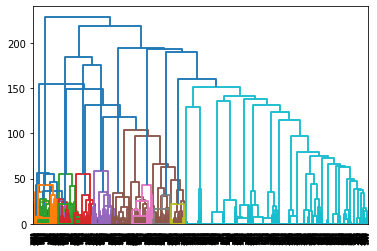

In [46]:
# Connectivity matrices by cosine similarity
map_df = synapse_df
# adj = pd.crosstab(map_df.pre_pt_root_id,map_df.post_pt_root_id)

# # # order inputs by sum
# adj_order = (MN_ordered_df  # Use `name` and `product` as index.
#          .assign(sum=MN_ordered_df.sum(axis=1))  # Add temporary 'sum' column to sum rows.
#          .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
#          .iloc[:, :-1])  # Remove temporary `sum` column.

# order inputs by cosine similarity
local_clustered = organize_by_cos_long(local_syn)
ascending_clustered = organize_by_cos_long(ascending_syn)
sensory_clustered = organize_by_cos_long(sensory_syn)
descending_clustered = organize_by_cos_long(descending_syn)
other_clustered = organize_by_cos_long(other_syn)
pmns_clustered = pd.concat([descending_clustered,sensory_clustered,ascending_clustered,local_clustered])#,other_clustered])
# pmns_clustered = local_clustered
# # order by sclerite

# ID_idx = leftMN_df.SegID
# sc_dict = leftMN_df.set_index('SegID')['sc_order'].to_dict()
# reordered_sc_dict = {k: sc_dict[k] for k in ID_idx}
# reordered_sc_labels_df =  pd.DataFrame(reordered_sc_dict.items(), columns=['SegID', 'sc'])

# sc_order = reordered_sc_labels_df.sort_values(by ="sc")

# reordered_by_sc = pmns_clustered.reindex(columns=sc_order.SegID)
# # MN labels
# ID_idx = reordered_by_sc.columns
# MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
# reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
# reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
# mn_ids = reordered_motor_labels_df.description


# pmns_clustered = organize_by_cos_long(map_df)

# order outputs by cosine similarity
# MN_ordered = organize_by_cos_short(map_df)
# adj_order = pmns_clustered.iloc[:,MN_ordered]


# ID_idx = adj_order.columns
# MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
# reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
# reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
# mn_ids = reordered_motor_labels_df.description



In [47]:
# pmns_clustered = pd.concat([descending_clustered,sensory_clustered,ascending_clustered,local_clustered])#,other_clustered])


# order by sclerite

ID_idx = MN_df.SegID
sc_dict = MN_df.set_index('SegID')['sc_order'].to_dict()
reordered_sc_dict = {k: sc_dict[k] for k in ID_idx}
reordered_sc_labels_df =  pd.DataFrame(reordered_sc_dict.items(), columns=['SegID', 'sc'])

sc_order = reordered_sc_labels_df.sort_values(by ="sc")
reordered_by_sc = pmns_clustered.reindex(columns=sc_order.SegID)

# MN labels
ID_idx = reordered_by_sc.columns
MN_dict = MN_df.set_index('SegID')['name'].to_dict()
reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
mn_ids = reordered_motor_labels_df.description


# adj_order2 = pmns_clustered.iloc[:,new_order]

# ID_idx = adj_order2.columns
# MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
# reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
# reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
# mn_ids = reordered_motor_labels_df.description

In [48]:
# pmn labels
ID_idx = reordered_by_sc.T.columns
pmn_dict = premotor_df.set_index('SegID')['cell_type'].to_dict()
reordered_pmn_dict = {k: pmn_dict[k] for k in ID_idx}
reordered_pmn_labels_df =  pd.DataFrame(reordered_pmn_dict.items(), columns=['SegID', 'description'])
pmn_ids = reordered_pmn_labels_df.description
pmn_ids

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1918     6B
1919    NaN
1920     3B
1921    18B
1922     6B
Name: description, Length: 1923, dtype: object

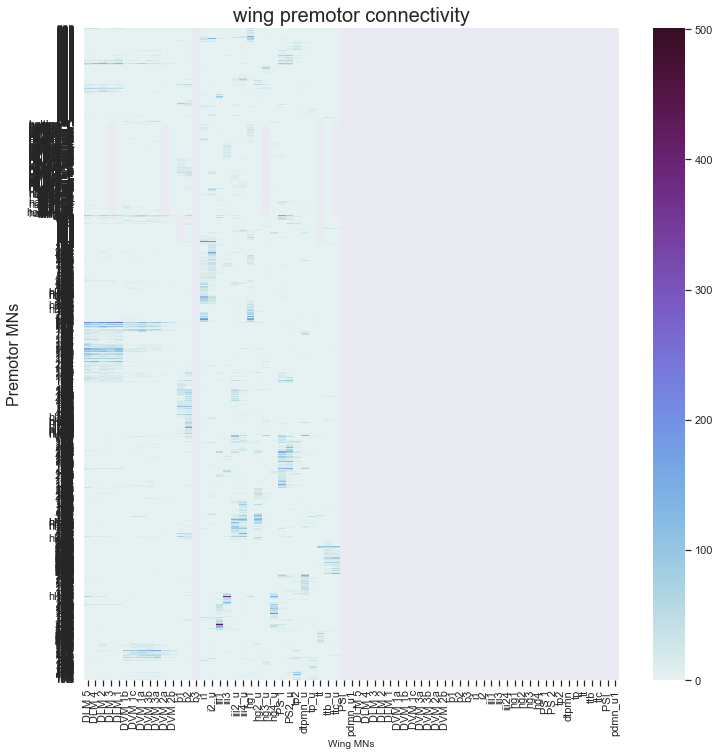

In [291]:
fig = plt.figure(1, figsize = [12,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense
# cmap = plt.set_cmap("rocket")
# adj_trunc = adj_order.transpose().iloc[18:22].transpose()
# all_reorderedLOG_df = np.log10(reordered_by_sc)
#pmn_ids = reordered_pmn_labels_df.description
ax = sns.heatmap(reordered_by_sc, xticklabels=mn_ids, yticklabels=pmn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
#plt.xticks(rotation = 90)
plt.title('wing premotor connectivity', size = 20)
#cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('Wing MNs', size = 10)
plt.ylabel('Premotor MNs', size = 16)

#plt.savefig('wingConnMatrix0818.svg', format='svg', bbox_inches='tight')
# plt.savefig('2Aconnmat.eps', format='eps', bbox_inches='tight')

plt.show()


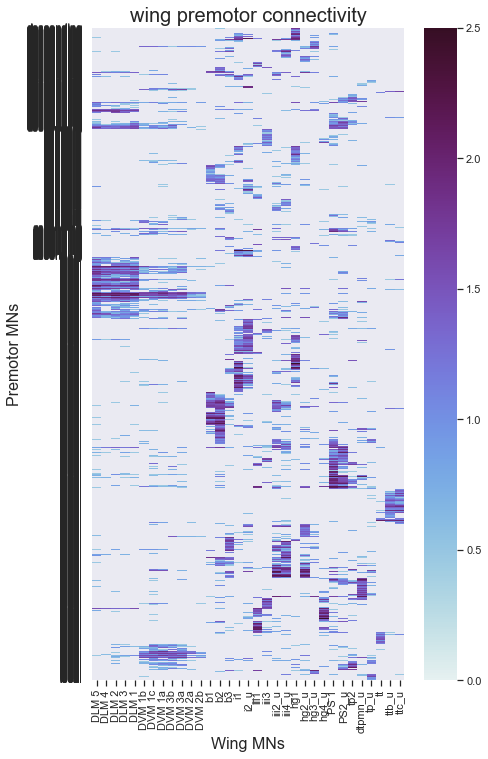

In [40]:
fig = plt.figure(1, figsize = [7,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense
# cmap = plt.set_cmap("rocket")
# adj_trunc = adj_order.transpose().iloc[18:22].transpose()
all_reorderedLOG_df = np.log10(reordered_by_sc)
#pmn_ids = reordered_pmn_labels_df.description
ax = sns.heatmap(all_reorderedLOG_df, vmin = 0, vmax = 2.5 , xticklabels=mn_ids, yticklabels=pmn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
#plt.xticks(rotation = 90)
plt.title('wing premotor connectivity', size = 20)
#cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('Wing MNs', size = 16)
plt.ylabel('Premotor MNs', size = 16)

#plt.savefig('wingConnMatrix0818.svg', format='svg', bbox_inches='tight')
# plt.savefig('wingConnMatrix0818.eps', format='eps', bbox_inches='tight')

plt.show()


In [41]:
reordered_by_sc

SegID,648518346472269618,648518346486629017,648518346486563887,648518346476906768,648518346515087943,648518346511825599,648518346483122508,648518346491784815,648518346488827114,648518346512153646,...,648518346492048172,648518346487480490,648518346492244419,648518346497125761,648518346486682876,648518346489660723,648518346472953700,648518346489942455,648518346494688675,648518346481319311
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346490023963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
648518346492203971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
648518346495942502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
648518346506598946,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
648518346504284908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346490185224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,0.0,0,0
648518346478671188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,0.0,0,0
648518346484173351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0.0,0,0


In [62]:
# this will need to be changed for leg

DLM_list = [648518346515087943, 648518346486563887, 648518346476906768, 648518346486629017, 648518346472269618]
DVM_list = [648518346491784815, 648518346511825599, 648518346483122508, 648518346499049025, 648518346509427075, 648518346512153646, 648518346488827114]
basalar_list = [648518346515574010, 648518346481269135, 648518346493634040]
firstAx_list = [648518346491984914, 648518346499256923]
thirdAx_list = [648518346488622926, 648518346509604297, 648518346491616529,648518346482131604]
hg_list = [648518346487480490, 648518346498479344, 648518346481779133, 648518346492048172]
PS_list = [648518346492244419, 648518346497125761, 648518346472953700]
tp_list = [648518346486682876, 648518346489660723]
tt_list = [648518346489942455, 648518346481319311, 648518346494688675]

temp_df = ut.build_synapse_df(MN_df.SegID.to_list(),"pre",3,client) 
temp_counts = pd.DataFrame(temp_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))
wing_list = DLM_list + DVM_list + basalar_list + firstAx_list + thirdAx_list + hg_list + PS_list + tp_list + tt_list

if temp_counts.shape[0] != len(wing_list):
    print('Warning: The following segIDs are not up to date')
    print(list(set(wing_list) - set(temp_counts['SegID'])))

[]


In [51]:
local_df

,SegID,counts,class,cell_type,notes1
0,648518346491506374,1723.0,local,19B,19B t1
1,648518346487847703,1291.0,local,3B,3B
2,648518346489656701,1274.0,local,20A,u_ primary
3,648518346486676988,1061.0,local,19B,19B t1
4,648518346479342290,920.0,local,19B,19Bb t2
...,...,...,...,...,...
2634,648518346520177489,7.0,local,18B,18B t3
2635,648518346492074540,7.0,local,13A,u_
2645,648518346486520964,7.0,local,NaN,u1B
2755,648518346478665556,6.0,local,6B,6B


In [63]:
# order pmns by preferred motor pool....
precounts = pd.DataFrame(syn_df['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

counts_syn = precounts
this_syn_df = syn_df

counts_syn['mn'] = ''
counts_syn['pmn'] = ''
counts_syn['other'] = ''

i = 0
while i < len(counts_syn):
    pmn_i = counts_syn.SegID.iloc[i]
    syn_i = this_syn_df[this_syn_df.pre_pt_root_id.isin([pmn_i])]

    mn_pmns = syn_i[syn_i['post_pt_root_id'].isin(MN_df.SegID.to_list())]

    counts_syn['mn'].iloc[i] = len(mn_pmns)

    i = i+1


this_syn_df = syn_df

counts_syn['DLM'] = ''
counts_syn['DVM'] = ''
counts_syn['basalar'] = ''
counts_syn['firstAx'] = ''
counts_syn['thirdAx'] = ''
counts_syn['hg'] = ''
counts_syn['PS'] = ''
counts_syn['tp'] = ''
counts_syn['tt'] = ''

i = 0
while i < len(counts_syn):
    pmn_i = counts_syn.SegID.iloc[i]
    syn_i = this_syn_df[this_syn_df.pre_pt_root_id.isin([pmn_i])]

    DLM_syn = syn_i[syn_i['post_pt_root_id'].isin(DLM_list)]
    DVM_syn = syn_i[syn_i['post_pt_root_id'].isin(DVM_list)]
    basalar_syn = syn_i[syn_i['post_pt_root_id'].isin(basalar_list)]
    firstAx_syn = syn_i[syn_i['post_pt_root_id'].isin(firstAx_list)]
    thirdAx_syn = syn_i[syn_i['post_pt_root_id'].isin(thirdAx_list)]
    hg_syn = syn_i[syn_i['post_pt_root_id'].isin(hg_list)]
    PS_syn = syn_i[syn_i['post_pt_root_id'].isin(PS_list)]
    tp_syn = syn_i[syn_i['post_pt_root_id'].isin(tp_list)]
    tt_syn = syn_i[syn_i['post_pt_root_id'].isin(tt_list)]

    counts_syn['DLM'].iloc[i] = len(DLM_syn)
    counts_syn['DVM'].iloc[i] = len(DVM_syn)
    counts_syn['basalar'].iloc[i] = len(basalar_syn)
    counts_syn['firstAx'].iloc[i] = len(firstAx_syn)
    counts_syn['thirdAx'].iloc[i] = len(thirdAx_syn)
    counts_syn['hg'].iloc[i] = len(hg_syn)
    counts_syn['PS'].iloc[i] = len(PS_syn)
    counts_syn['tp'].iloc[i] = len(tp_syn)
    counts_syn['tt'].iloc[i] = len(tt_syn)

    i = i+1

# assign a frational value to pseudo rank order
proportion_df = counts_syn.iloc[:,0:1]
proportion_df['DLM'] = counts_syn.DLM / counts_syn.mn
proportion_df['DVM'] = counts_syn.DVM / counts_syn.mn
proportion_df['basalar'] = counts_syn.basalar / counts_syn.mn
proportion_df['firstAx'] = counts_syn.firstAx / counts_syn.mn
proportion_df['thirdAx'] = counts_syn.thirdAx / counts_syn.mn
proportion_df['hg'] = counts_syn.hg / counts_syn.mn
proportion_df['PS'] = counts_syn.PS / counts_syn.mn
proportion_df['tp'] = counts_syn.tp / counts_syn.mn
proportion_df['tt'] = counts_syn.tt / counts_syn.mn

proportion_df = proportion_df.reset_index(drop = True)

# assign motor pool
proportion_df['pref'] = ''
temp_df = proportion_df.iloc[:,1:-1].astype(float)

i = 0
while i < len(proportion_df):
    proportion_df['pref'].iloc[i] = temp_df.loc[i].idxmax()
    i = i +1

/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [45]:
proportion_df.head()

,SegID,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp,tt,pref
0,648518346491506374,0.62159,0.326175,0.012188,0.0,0.013929,0.021474,0.004643,0.0,0.0,DLM
1,648518346487847703,0.0,0.0,0.429125,0.0,0.422153,0.123935,0.017816,0.004648,0.0,basalar
2,648518346489656701,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0,thirdAx
3,648518346486676988,0.658812,0.317625,0.0,0.0,0.006598,0.008483,0.008483,0.0,0.0,DLM
4,648518346479342290,0.672826,0.327174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DLM


In [64]:
# order inputs by preferred sclerite pool - no way does this code have to be so long but its not slow
DLM_pref = proportion_df[proportion_df.pref.isin(['DLM'])]
DVM_pref = proportion_df[proportion_df.pref.isin(['DVM'])]
basalar_pref = proportion_df[proportion_df.pref.isin(['basalar'])]
firstAx_pref = proportion_df[proportion_df.pref.isin(['firstAx'])]
thirdAx_pref = proportion_df[proportion_df.pref.isin(['thirdAx'])]
hg_pref = proportion_df[proportion_df.pref.isin(['hg'])]
PS_pref = proportion_df[proportion_df.pref.isin(['PS'])]
tp_pref = proportion_df[proportion_df.pref.isin(['tp'])]
tt_pref = proportion_df[proportion_df.pref.isin(['tt'])]

DLM_syn = syn_df[syn_df.pre_pt_root_id.isin(DLM_pref.SegID.to_list())]
DVM_syn = syn_df[syn_df.pre_pt_root_id.isin(DVM_pref.SegID.to_list())]
basalar_syn = syn_df[syn_df.pre_pt_root_id.isin(basalar_pref.SegID.to_list())]
firstAx_syn = syn_df[syn_df.pre_pt_root_id.isin(firstAx_pref.SegID.to_list())]
thirdAx_syn = syn_df[syn_df.pre_pt_root_id.isin(thirdAx_pref.SegID.to_list())]
hg_syn = syn_df[syn_df.pre_pt_root_id.isin(hg_pref.SegID.to_list())]
PS_syn = syn_df[syn_df.pre_pt_root_id.isin(PS_pref.SegID.to_list())]
tp_syn = syn_df[syn_df.pre_pt_root_id.isin(tp_pref.SegID.to_list())]
tt_syn = syn_df[syn_df.pre_pt_root_id.isin(tt_pref.SegID.to_list())]


type_df = local_df
DLM_syn_ = DLM_syn[DLM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DLM_adj_ = pd.crosstab(DLM_syn_['pre_pt_root_id'],DLM_syn_['post_pt_root_id'])
# # # order inputs by sum
DLM_adj_ = (DLM_adj_  # Use `name` and `product` as index.
         .assign(sum=DLM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

DVM_syn_ = DVM_syn[DVM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DVM_adj_ = pd.crosstab(DVM_syn_['pre_pt_root_id'],DVM_syn_['post_pt_root_id'])
DVM_adj_ = (DVM_adj_  # Use `name` and `product` as index.
         .assign(sum=DVM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

basalar_syn_ = basalar_syn[basalar_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
basalar_adj_ = pd.crosstab(basalar_syn_['pre_pt_root_id'],basalar_syn_['post_pt_root_id'])
basalar_adj_ = (basalar_adj_  # Use `name` and `product` as index.
         .assign(sum=basalar_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

firstAx_syn_ = firstAx_syn[firstAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
firstAx_adj_ = pd.crosstab(firstAx_syn_['pre_pt_root_id'],firstAx_syn_['post_pt_root_id'])
firstAx_adj_ = (firstAx_adj_  # Use `name` and `product` as index.
         .assign(sum=firstAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

thirdAx_syn_ = thirdAx_syn[thirdAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
thirdAx_adj_ = pd.crosstab(thirdAx_syn_['pre_pt_root_id'],thirdAx_syn_['post_pt_root_id'])
thirdAx_adj_ = (thirdAx_adj_  # Use `name` and `product` as index.
         .assign(sum=thirdAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

hg_syn_ = hg_syn[hg_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
hg_adj_ = pd.crosstab(hg_syn_['pre_pt_root_id'],hg_syn_['post_pt_root_id'])
hg_adj_ = (hg_adj_  # Use `name` and `product` as index.
         .assign(sum=hg_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

PS_syn_ = PS_syn[PS_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
PS_adj_ = pd.crosstab(PS_syn_['pre_pt_root_id'],PS_syn_['post_pt_root_id'])
PS_adj_ = (PS_adj_  # Use `name` and `product` as index.
         .assign(sum=PS_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tp_syn_ = tp_syn[tp_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tp_adj_ = pd.crosstab(tp_syn_['pre_pt_root_id'],tp_syn_['post_pt_root_id'])
tp_adj_ = (tp_adj_  # Use `name` and `product` as index.
         .assign(sum=tp_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tt_syn_ = tt_syn[tt_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tt_adj_ = pd.crosstab(tt_syn_['pre_pt_root_id'],tt_syn_['post_pt_root_id'])
tt_adj_ = (tt_adj_  # Use `name` and `product` as index.
         .assign(sum=tt_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

local_clustered_by_sc_syn = pd.concat([DLM_adj_,DVM_adj_,basalar_adj_,firstAx_adj_,thirdAx_adj_,hg_adj_,PS_adj_,tp_adj_, tt_adj_])#,unknown_adj_])

type_df = ascending_df
DLM_syn_ = DLM_syn[DLM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DLM_adj_ = pd.crosstab(DLM_syn_['pre_pt_root_id'],DLM_syn_['post_pt_root_id'])
DLM_adj_ = (DLM_adj_  # Use `name` and `product` as index.
         .assign(sum=DLM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

DVM_syn_ = DVM_syn[DVM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DVM_adj_ = pd.crosstab(DVM_syn_['pre_pt_root_id'],DVM_syn_['post_pt_root_id'])
DVM_adj_ = (DVM_adj_  # Use `name` and `product` as index.
         .assign(sum=DVM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

basalar_syn_ = basalar_syn[basalar_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
basalar_adj_ = pd.crosstab(basalar_syn_['pre_pt_root_id'],basalar_syn_['post_pt_root_id'])
basalar_adj_ = (basalar_adj_  # Use `name` and `product` as index.
         .assign(sum=basalar_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

firstAx_syn_ = firstAx_syn[firstAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
firstAx_adj_ = pd.crosstab(firstAx_syn_['pre_pt_root_id'],firstAx_syn_['post_pt_root_id'])
firstAx_adj_ = (firstAx_adj_  # Use `name` and `product` as index.
         .assign(sum=firstAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

thirdAx_syn_ = thirdAx_syn[thirdAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
thirdAx_adj_ = pd.crosstab(thirdAx_syn_['pre_pt_root_id'],thirdAx_syn_['post_pt_root_id'])
thirdAx_adj_ = (thirdAx_adj_  # Use `name` and `product` as index.
         .assign(sum=thirdAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

hg_syn_ = hg_syn[hg_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
hg_adj_ = pd.crosstab(hg_syn_['pre_pt_root_id'],hg_syn_['post_pt_root_id'])
hg_adj_ = (hg_adj_  # Use `name` and `product` as index.
         .assign(sum=hg_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

PS_syn_ = PS_syn[PS_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
PS_adj_ = pd.crosstab(PS_syn_['pre_pt_root_id'],PS_syn_['post_pt_root_id'])
PS_adj_ = (PS_adj_  # Use `name` and `product` as index.
         .assign(sum=PS_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tp_syn_ = tp_syn[tp_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tp_adj_ = pd.crosstab(tp_syn_['pre_pt_root_id'],tp_syn_['post_pt_root_id'])
tp_adj_ = (tp_adj_  # Use `name` and `product` as index.
         .assign(sum=tp_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tt_syn_ = tt_syn[tt_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tt_adj_ = pd.crosstab(tt_syn_['pre_pt_root_id'],tt_syn_['post_pt_root_id'])
tt_adj_ = (tt_adj_  # Use `name` and `product` as index.
         .assign(sum=tt_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

ascending_clustered_by_sc_syn = pd.concat([DLM_adj_,DVM_adj_,basalar_adj_,firstAx_adj_,thirdAx_adj_,hg_adj_,PS_adj_,tp_adj_, tt_adj_])#,unknown_adj_])

type_df = sensory_df
DLM_syn_ = DLM_syn[DLM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DLM_adj_ = pd.crosstab(DLM_syn_['pre_pt_root_id'],DLM_syn_['post_pt_root_id'])
DLM_adj_ = (DLM_adj_  # Use `name` and `product` as index.
         .assign(sum=DLM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

DVM_syn_ = DVM_syn[DVM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DVM_adj_ = pd.crosstab(DVM_syn_['pre_pt_root_id'],DVM_syn_['post_pt_root_id'])
DVM_adj_ = (DVM_adj_  # Use `name` and `product` as index.
         .assign(sum=DVM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

basalar_syn_ = basalar_syn[basalar_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
basalar_adj_ = pd.crosstab(basalar_syn_['pre_pt_root_id'],basalar_syn_['post_pt_root_id'])
basalar_adj_ = (basalar_adj_  # Use `name` and `product` as index.
         .assign(sum=basalar_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

firstAx_syn_ = firstAx_syn[firstAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
firstAx_adj_ = pd.crosstab(firstAx_syn_['pre_pt_root_id'],firstAx_syn_['post_pt_root_id'])
firstAx_adj_ = (firstAx_adj_  # Use `name` and `product` as index.
         .assign(sum=firstAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

thirdAx_syn_ = thirdAx_syn[thirdAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
thirdAx_adj_ = pd.crosstab(thirdAx_syn_['pre_pt_root_id'],thirdAx_syn_['post_pt_root_id'])
thirdAx_adj_ = (thirdAx_adj_  # Use `name` and `product` as index.
         .assign(sum=thirdAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

hg_syn_ = hg_syn[hg_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
hg_adj_ = pd.crosstab(hg_syn_['pre_pt_root_id'],hg_syn_['post_pt_root_id'])
hg_adj_ = (hg_adj_  # Use `name` and `product` as index.
         .assign(sum=hg_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

PS_syn_ = PS_syn[PS_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
PS_adj_ = pd.crosstab(PS_syn_['pre_pt_root_id'],PS_syn_['post_pt_root_id'])
PS_adj_ = (PS_adj_  # Use `name` and `product` as index.
         .assign(sum=PS_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tp_syn_ = tp_syn[tp_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tp_adj_ = pd.crosstab(tp_syn_['pre_pt_root_id'],tp_syn_['post_pt_root_id'])
tp_adj_ = (tp_adj_  # Use `name` and `product` as index.
         .assign(sum=tp_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tt_syn_ = tt_syn[tt_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tt_adj_ = pd.crosstab(tt_syn_['pre_pt_root_id'],tt_syn_['post_pt_root_id'])
tt_adj_ = (tt_adj_  # Use `name` and `product` as index.
         .assign(sum=tt_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

sensory_clustered_by_sc_syn = pd.concat([DLM_adj_,DVM_adj_,basalar_adj_,firstAx_adj_,thirdAx_adj_,hg_adj_,PS_adj_,tp_adj_, tt_adj_])#,unknown_adj_])

type_df = descending_df
DLM_syn_ = DLM_syn[DLM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DLM_adj_ = pd.crosstab(DLM_syn_['pre_pt_root_id'],DLM_syn_['post_pt_root_id'])
DLM_adj_ = (DLM_adj_  # Use `name` and `product` as index.
         .assign(sum=DLM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

DVM_syn_ = DVM_syn[DVM_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
DVM_adj_ = pd.crosstab(DVM_syn_['pre_pt_root_id'],DVM_syn_['post_pt_root_id'])
DVM_adj_ = (DVM_adj_  # Use `name` and `product` as index.
         .assign(sum=DVM_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

basalar_syn_ = basalar_syn[basalar_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
basalar_adj_ = pd.crosstab(basalar_syn_['pre_pt_root_id'],basalar_syn_['post_pt_root_id'])
basalar_adj_ = (basalar_adj_  # Use `name` and `product` as index.
         .assign(sum=basalar_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

firstAx_syn_ = firstAx_syn[firstAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
firstAx_adj_ = pd.crosstab(firstAx_syn_['pre_pt_root_id'],firstAx_syn_['post_pt_root_id'])
firstAx_adj_ = (firstAx_adj_  # Use `name` and `product` as index.
         .assign(sum=firstAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

thirdAx_syn_ = thirdAx_syn[thirdAx_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
thirdAx_adj_ = pd.crosstab(thirdAx_syn_['pre_pt_root_id'],thirdAx_syn_['post_pt_root_id'])
thirdAx_adj_ = (thirdAx_adj_  # Use `name` and `product` as index.
         .assign(sum=thirdAx_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

hg_syn_ = hg_syn[hg_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
hg_adj_ = pd.crosstab(hg_syn_['pre_pt_root_id'],hg_syn_['post_pt_root_id'])
hg_adj_ = (hg_adj_  # Use `name` and `product` as index.
         .assign(sum=hg_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

PS_syn_ = PS_syn[PS_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
PS_adj_ = pd.crosstab(PS_syn_['pre_pt_root_id'],PS_syn_['post_pt_root_id'])
PS_adj_ = (PS_adj_  # Use `name` and `product` as index.
         .assign(sum=PS_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tp_syn_ = tp_syn[tp_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tp_adj_ = pd.crosstab(tp_syn_['pre_pt_root_id'],tp_syn_['post_pt_root_id'])
tp_adj_ = (tp_adj_  # Use `name` and `product` as index.
         .assign(sum=tp_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

tt_syn_ = tt_syn[tt_syn.pre_pt_root_id.isin(type_df.SegID.to_list())]
tt_adj_ = pd.crosstab(tt_syn_['pre_pt_root_id'],tt_syn_['post_pt_root_id'])
tt_adj_ = (tt_adj_  # Use `name` and `product` as index.
         .assign(sum=tt_adj_.sum(axis=1))  # Add temporary 'sum' column to sum rows.
         .sort_values(by='sum', ascending=False)  # Sort by row sum descending order.
         .iloc[:, :-1])  # Remove temporary `sum` column.

descending_clustered_by_sc_syn = pd.concat([DLM_adj_,DVM_adj_,basalar_adj_,firstAx_adj_,thirdAx_adj_,hg_adj_,PS_adj_,tp_adj_, tt_adj_])#,unknown_adj_])

pmns_clustered_by_sc = pd.concat([descending_clustered_by_sc_syn,sensory_clustered_by_sc_syn,ascending_clustered_by_sc_syn,local_clustered_by_sc_syn])

# order by sclerite

ID_idx = leftMN_df.SegID
sc_dict = leftMN_df.set_index('SegID')['sc_order'].to_dict()
reordered_sc_dict = {k: sc_dict[k] for k in ID_idx}
reordered_sc_labels_df =  pd.DataFrame(reordered_sc_dict.items(), columns=['SegID', 'sc'])

sc_order = reordered_sc_labels_df.sort_values(by ="sc")
reordered_by_sc = pmns_clustered_by_sc.reindex(columns=sc_order.SegID)

# MN labels
ID_idx = reordered_by_sc.columns
MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
mn_ids = reordered_motor_labels_df.description

In [65]:
pmns_clustered_by_sc = pd.concat([descending_clustered_by_sc_syn,sensory_clustered_by_sc_syn,ascending_clustered_by_sc_syn,local_clustered_by_sc_syn])

# order by sclerite

ID_idx = leftMN_df.SegID
sc_dict = leftMN_df.set_index('SegID')['sc_order'].to_dict()
reordered_sc_dict = {k: sc_dict[k] for k in ID_idx}
reordered_sc_labels_df =  pd.DataFrame(reordered_sc_dict.items(), columns=['SegID', 'sc'])

sc_order = reordered_sc_labels_df.sort_values(by ="sc")
reordered_by_sc = pmns_clustered_by_sc.reindex(columns=sc_order.SegID)

# MN labels
ID_idx = reordered_by_sc.columns
MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
mn_ids = reordered_motor_labels_df.description
reordered_by_sc.shape

(1923, 33)

In [66]:
len(local_syn) + len(ascending_syn) + len(sensory_syn) + len(descending_syn)

171507

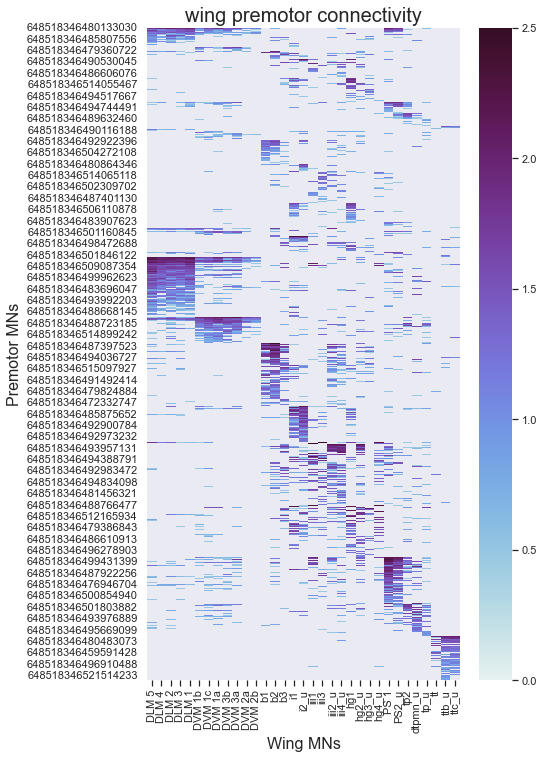

In [49]:
fig = plt.figure(1, figsize = [7,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense
# cmap = plt.set_cmap("rocket")
# adj_trunc = adj_order.transpose().iloc[18:22].transpose()
all_reorderedLOG_df = np.log10(reordered_by_sc)
#pmn_ids = reordered_pmn_labels_df.description
ax = sns.heatmap(all_reorderedLOG_df, vmin = 0, vmax = 2.5 , xticklabels=mn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
#plt.xticks(rotation = 90)
plt.title('wing premotor connectivity', size = 20)
#cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('Wing MNs', size = 16)
plt.ylabel('Premotor MNs', size = 16)

#plt.savefig('wingConnMatrix0818.svg', format='svg', bbox_inches='tight')
# plt.savefig('wingConnMatrix0823.eps', format='eps', bbox_inches='tight')

plt.show()


In [50]:
descending_clustered_by_sc_syn.iloc[:20,:]

post_pt_root_id,648518346472269618,648518346472953700,648518346476906768,648518346481269135,648518346481779133,648518346482131604,648518346483122508,648518346486563887,648518346486629017,648518346486682876,...,648518346499256923,648518346499823171,648518346509427075,648518346511825599,648518346512153646,648518346515087943,648518346494407701,648518346509604297,648518346481319311,648518346489942455
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346480133030,58.0,3.0,79.0,0.0,0.0,3.0,41.0,134.0,98.0,0.0,...,0.0,0.0,11.0,29.0,31.0,117.0,NaN,NaN,NaN,NaN
648518346470309374,64.0,4.0,85.0,0.0,0.0,0.0,40.0,97.0,93.0,0.0,...,0.0,0.0,13.0,18.0,35.0,97.0,NaN,NaN,NaN,NaN
648518346500565427,71.0,0.0,48.0,0.0,0.0,0.0,0.0,57.0,65.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.0,NaN,NaN,NaN,NaN
648518346500936470,29.0,0.0,18.0,34.0,0.0,13.0,0.0,14.0,18.0,0.0,...,0.0,31.0,0.0,0.0,0.0,23.0,NaN,NaN,NaN,NaN
648518346459520004,17.0,0.0,29.0,0.0,0.0,0.0,19.0,23.0,11.0,3.0,...,0.0,0.0,3.0,7.0,10.0,43.0,NaN,NaN,NaN,NaN
648518346490882081,33.0,0.0,26.0,0.0,0.0,0.0,11.0,28.0,20.0,0.0,...,0.0,0.0,0.0,5.0,6.0,49.0,NaN,NaN,NaN,NaN
648518346518572767,26.0,4.0,13.0,0.0,66.0,0.0,3.0,19.0,17.0,0.0,...,0.0,0.0,9.0,38.0,0.0,40.0,NaN,NaN,NaN,NaN
648518346470346238,59.0,0.0,31.0,0.0,0.0,0.0,16.0,19.0,16.0,0.0,...,0.0,0.0,0.0,7.0,0.0,34.0,NaN,NaN,NaN,NaN
648518346517438244,26.0,0.0,12.0,0.0,35.0,0.0,13.0,19.0,11.0,0.0,...,5.0,0.0,8.0,6.0,8.0,11.0,NaN,NaN,NaN,NaN


In [67]:
pmns_clustered_by_sc = pd.concat([descending_clustered_by_sc_syn,sensory_clustered_by_sc_syn,ascending_clustered_by_sc_syn,local_clustered_by_sc_syn])

# pmns_clustered_by_sc = pd.concat([sensory_clustered_by_sc_syn,ascending_clustered_by_sc_syn,descending_clustered_by_sc_syn])


# order by sclerite

ID_idx = leftMN_df.SegID
sc_dict = leftMN_df.set_index('SegID')['sc_order'].to_dict()
reordered_sc_dict = {k: sc_dict[k] for k in ID_idx}
reordered_sc_labels_df =  pd.DataFrame(reordered_sc_dict.items(), columns=['SegID', 'sc'])

sc_order = reordered_sc_labels_df.sort_values(by ="sc")
reordered_by_sc = pmns_clustered_by_sc.reindex(columns=sc_order.SegID)


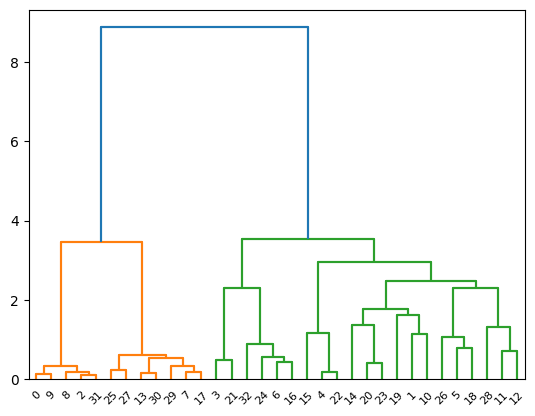

In [88]:
map_df = synapse_df
adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
# adj = local_clustered_by_sc_syn.fillna(0)
# adj = reordered_by_sc.fillna(0) # to only use pmns that are in the connectivity matrix (i.e. not unknowns)
sim_mat_temp = cosine_similarity(adj.to_numpy().transpose())
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
reordered_df = adj.iloc[:,clustered_order]
sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())
sim_mat0 = sim_mat.copy()


# # order by sclerite
ID_idx = leftMN_df.SegID
sc_dict = leftMN_df.set_index('SegID')['sc_order'].to_dict()
reordered_sc_dict = {k: sc_dict[k] for k in ID_idx}
reordered_sc_labels_df =  pd.DataFrame(reordered_sc_dict.items(), columns=['SegID', 'sc'])

sc_order = reordered_sc_labels_df.sort_values(by ="sc")
reordered_by_sc = adj.reindex(columns=sc_order.SegID)

# MN labels
ID_idx = reordered_by_sc.columns
MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
mn_ids = reordered_motor_labels_df.description

# sim_mat = cosine_similarity(reordered_by_sc.to_numpy().transpose())


# ID_idx = reordered_df.columns
# MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
# reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
# reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
# mn_ids = reordered_motor_labels_df.description


In [69]:
reordered_df = adj.reindex(columns=sc_order.SegID)
# for sensory - missing TT
reordered_df['648518346489942455'] = 0
# sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())
ID_idx = leftMN_df.SegID
sc_dict = leftMN_df.set_index('SegID')['sc_order'].to_dict()
reordered_sc_dict = {k: sc_dict[k] for k in ID_idx}
reordered_sc_labels_df =  pd.DataFrame(reordered_sc_dict.items(), columns=['SegID', 'sc'])

sc_order = reordered_sc_labels_df.sort_values(by ="sc")
reordered_by_sc = reordered_df.reindex(columns=sc_order.SegID).fillna(0)
sim_mat = cosine_similarity(reordered_by_sc.to_numpy().transpose())

# MN labels
ID_idx = reordered_by_sc.columns
MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
mn_ids = reordered_motor_labels_df.description

In [54]:
reordered_by_sc

SegID,648518346472269618,648518346486629017,648518346486563887,648518346476906768,648518346515087943,648518346511825599,648518346483122508,648518346491784815,648518346488827114,648518346512153646,...,648518346492048172,648518346487480490,648518346492244419,648518346497125761,648518346486682876,648518346489660723,648518346472953700,648518346489942455,648518346494688675,648518346481319311
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346491506374,213,163.0,203,231.0,261.0,77,68.0,130.0,86.0,104.0,...,4.0,0,0,8,0.0,0.0,0,0.0,0.0,0.0
648518346486676988,157,113.0,136,147.0,146.0,49,44.0,86.0,54.0,65.0,...,0.0,0,0,9,0.0,0.0,0,0.0,0.0,0.0
648518346479342290,106,114.0,134,112.0,153.0,44,53.0,77.0,56.0,51.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
648518346500367797,101,78.0,125,88.0,112.0,28,76.0,86.0,78.0,63.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
648518346491866991,166,108.0,124,111.0,160.0,19,23.0,52.0,7.0,19.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346492074540,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,7.0,0.0
648518346489688627,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,7.0,0.0
648518346486520964,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,7.0,0.0


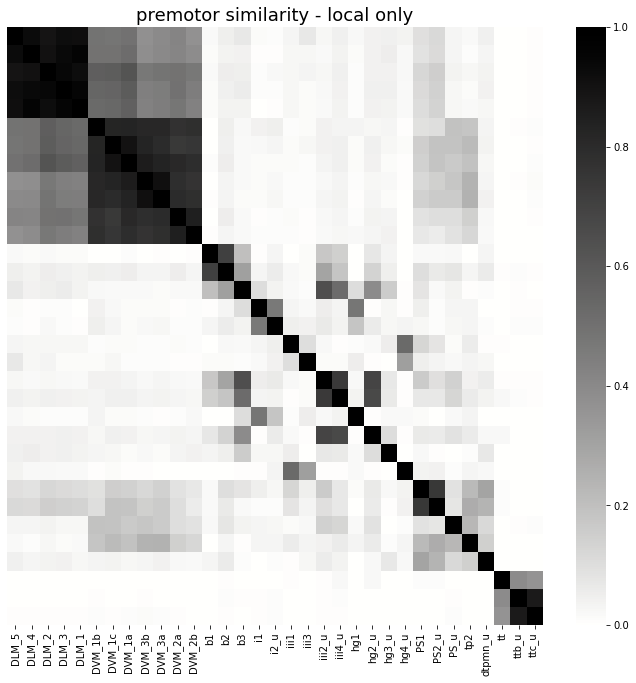

In [70]:
fig = plt.figure(1, figsize = [12,11])
#ax = sns.heatmap(sim_mat)#, xticklabels=mn_ids, yticklabels=lbls)
#ax = sns.heatmap(sim_mat, xticklabels=mn_ids, yticklabels=lbls)
cmap = cmocean.cm.gray_r
# from matplotlib.colors import 

ax = sns.heatmap(sim_mat, xticklabels=mn_ids, yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
# plt.set_cmap("plasma")

cbar = ax.collections[0].colorbar

#plt.title
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
#cbar.ax.tick_params(labelsize=20)
#cbar.set_label(label = 'cosine similarity', size=24)
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('premotor similarity - local only', fontsize = 18)
#plt.ylabel('wing MNs', fontsize =18)
#plt.yticks(fontsize = 16)
#plt.xticks(fontsize = 16)
# plt.savefig('cosSimLoc_0823.svg', format='svg', bbox_inches='tight')

plt.show()

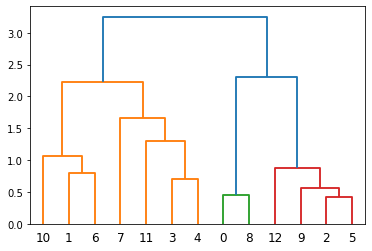

In [71]:
# direct MNs onky
directMNs = basalar_list + firstAx_list + thirdAx_list + hg_list
map_df = synapse_df[synapse_df.post_pt_root_id.isin(directMNs)]
adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])

sim_mat_temp = cosine_similarity(adj.to_numpy().transpose())
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
reordered_df = adj.iloc[:,clustered_order]
sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())


# MN labels
ID_idx = reordered_df.columns
MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
mn_ids = reordered_motor_labels_df.description

# sim_mat = cosine_similarity(reordered_by_sc.to_numpy().transpose())


# ID_idx = reordered_df.columns
# MN_dict = leftMN_df.set_index('SegID')['name'].to_dict()
# reordered_MN_dict = {k: MN_dict[k] for k in ID_idx}
# reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
# mn_ids = reordered_motor_labels_df.description


In [59]:
map_df.post_pt_root_id.value_counts()

648518346493634040    10610
648518346482131604     9095
648518346481779133     8855
648518346499256923     8486
648518346491616529     8430
648518346498479344     6468
648518346487480490     5895
648518346481269135     5436
648518346509604297     4655
648518346492048172     2235
Name: post_pt_root_id, dtype: int64

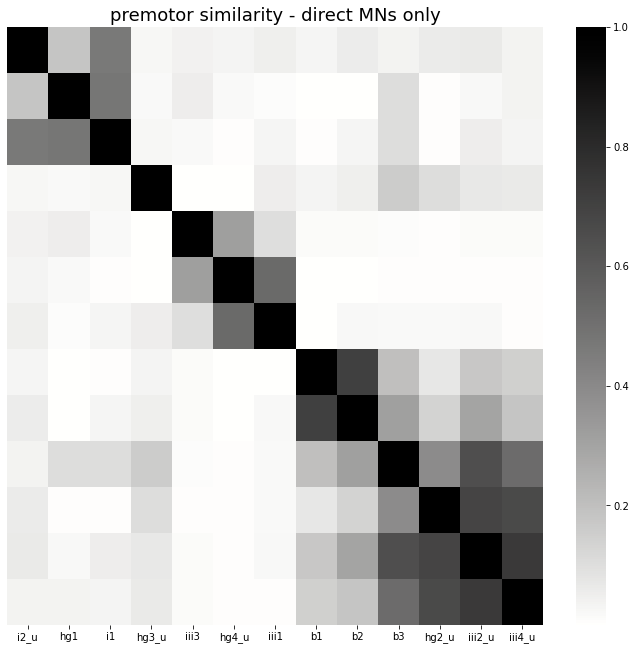

In [73]:
fig = plt.figure(1, figsize = [12,11])
#ax = sns.heatmap(sim_mat)#, xticklabels=mn_ids, yticklabels=lbls)
#ax = sns.heatmap(sim_mat, xticklabels=mn_ids, yticklabels=lbls)
cmap = cmocean.cm.gray_r
# from matplotlib.colors import 

ax = sns.heatmap(sim_mat, xticklabels=mn_ids, yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
# plt.set_cmap("plasma")

cbar = ax.collections[0].colorbar

#plt.title
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

# here set the labelsize by 20
#cbar.ax.tick_params(labelsize=20)
#cbar.set_label(label = 'cosine similarity', size=24)
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('premotor similarity - direct MNs only', fontsize = 18)
#plt.ylabel('wing MNs', fontsize =18)
#plt.yticks(fontsize = 16)
#plt.xticks(fontsize = 16)
plt.savefig('cosSimdirectMNs_1001.svg', format='svg', bbox_inches='tight')

plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


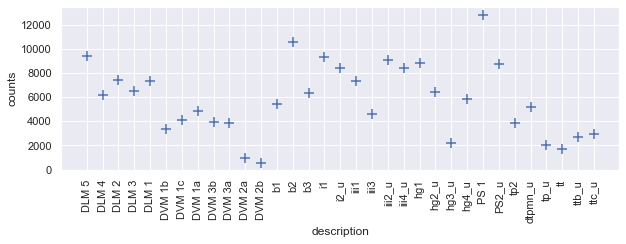

In [59]:

reordered_motor_labels_df.merge(postcounts).plot.scatter(x = 'description', y = 'counts', rot = 90, marker='+', s = 100, figsize = (10,3))
# plt.savefig('total_syn.svg', format='svg', bbox_inches='tight')

plt.show()

In [89]:
# same as above but number of presynaptic partners, not synapses
MN_partners = reordered_motor_labels_df.iloc[:,0:2]
MN_partners['all'] = ''
MN_partners['desc'] = ''
MN_partners['sen'] = ''
MN_partners['asc'] = ''
MN_partners['loc'] = ''
# MN_partners['frag'] = ''

i = 0
while i < len(MN_partners):
    iMN = MN_partners.SegID[i]
    i_syn_df = syn_df[syn_df.post_pt_root_id.isin([iMN])]
    MN_partners['all'].iloc[i] = len(i_syn_df.pre_pt_root_id.value_counts())
    MN_partners['desc'].iloc[i] = len(i_syn_df[i_syn_df.pre_pt_root_id.isin(descending_df.SegID.to_list())].pre_pt_root_id.value_counts())
    MN_partners['sen'].iloc[i] = len(i_syn_df[i_syn_df.pre_pt_root_id.isin(sensory_df.SegID.to_list())].pre_pt_root_id.value_counts())
    MN_partners['asc'].iloc[i] = len(i_syn_df[i_syn_df.pre_pt_root_id.isin(ascending_df.SegID.to_list())].pre_pt_root_id.value_counts())
    MN_partners['loc'].iloc[i] = len(i_syn_df[i_syn_df.pre_pt_root_id.isin(local_df.SegID.to_list())].pre_pt_root_id.value_counts())
    i = i +1

MN_partners = MN_partners.assign(frag=lambda x: (MN_partners['all'] - (MN_partners['desc'] + MN_partners['sen'] + MN_partners['asc'] + MN_partners['loc'])))
MN_partners


/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,SegID,description,all,desc,sen,asc,loc,frag
0,648518346472269618,DLM_5,494,64,10,14,256,150
1,648518346486629017,DLM_4,348,45,4,12,197,90
2,648518346486563887,DLM_2,409,53,2,15,240,99
3,648518346476906768,DLM_3,405,60,1,12,227,105
4,648518346515087943,DLM_1,381,58,2,13,205,103
5,648518346511825599,DVM_1b,283,31,15,15,170,52
6,648518346483122508,DVM_1c,330,34,18,20,199,59
7,648518346491784815,DVM_1a,325,38,18,15,182,72
8,648518346488827114,DVM_3b,295,45,14,14,164,58
9,648518346512153646,DVM_3a,264,32,15,13,151,53


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


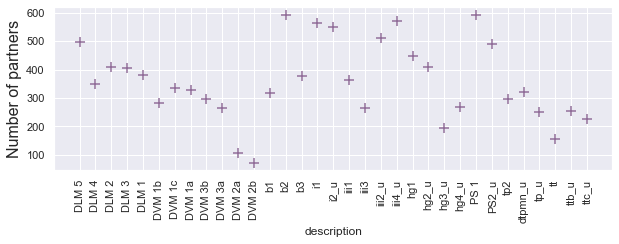

In [151]:

p = MN_partners.plot.scatter(x = 'description', y = 'all', rot = 90, marker='+', s = 100, figsize = (10,3))
p.set_ylabel("Number of partners",fontsize = 16)

plt.savefig('partnerNum.svg', format='svg', bbox_inches='tight')
plt.show()

In [75]:
MN_partners.iloc[:,2:] = MN_partners.iloc[:,2:].astype(float)

In [90]:
# proportion df
partners_proportion_df = MN_partners.iloc[:,1:2]
partners_proportion_df['loc'] = MN_partners['loc'] / (MN_partners['all'] - MN_partners.frag)
partners_proportion_df['asc'] = MN_partners.asc / (MN_partners['all'] - MN_partners.frag)
partners_proportion_df['sen'] = MN_partners.sen /(MN_partners['all'] - MN_partners.frag)
partners_proportion_df['desc'] = MN_partners.desc / (MN_partners['all'] - MN_partners.frag)
# partners_proportion_df['frag'] = MN_partners.frag / MN_partners['all']

partners_proportion_df

,description,loc,asc,sen,desc
0,DLM_5,0.744186,0.040698,0.02907,0.186047
1,DLM_4,0.763566,0.046512,0.015504,0.174419
2,DLM_2,0.774194,0.048387,0.006452,0.170968
3,DLM_3,0.756667,0.04,0.003333,0.2
4,DLM_1,0.73741,0.046763,0.007194,0.208633
5,DVM_1b,0.735931,0.064935,0.064935,0.134199
6,DVM_1c,0.734317,0.073801,0.066421,0.125461
7,DVM_1a,0.719368,0.059289,0.071146,0.150198
8,DVM_3b,0.691983,0.059072,0.059072,0.189873
9,DVM_3a,0.71564,0.061611,0.07109,0.151659


In [91]:
MN_meas_df = pd.read_csv('leftMN_measurements.csv')

partners_proportion_df['name'] = partners_proportion_df['description']
df = partners_proportion_df.merge(MN_meas_df, on = 'name', how = 'left')


In [92]:
df.head()

,description,loc,asc,sen,desc,name,Unnamed: 0,vol_um,area_um,SegID,tot_syn,n_prepart,Dmax,Dmin,AxArea_um,sc_order,ax_perim
0,DLM_5,0.744186,0.040698,0.02907,0.186047,DLM_5,13,8726.792387,34315.428633,648518346472269618,9465,494,2.90,1.95,4.439175,0,7.687713
1,DLM_4,0.763566,0.046512,0.015504,0.174419,DLM_4,24,6650.660668,26511.388570,648518346486629017,6198,347,2.34,1.77,3.251313,1,6.483765
2,DLM_2,0.774194,0.048387,0.006452,0.170968,DLM_2,14,7550.687872,35015.041175,648518346486563887,7429,410,3.00,1.57,3.697350,2,7.351617
3,DLM_3,0.756667,0.04,0.003333,0.2,DLM_3,23,7461.482163,31762.636658,648518346476906768,6559,405,2.17,1.84,3.134348,3,6.306364
4,DLM_1,0.73741,0.046763,0.007194,0.208633,DLM_1,7,8115.215765,32633.055066,648518346515087943,7330,381,2.53,2.48,4.925404,4,7.865896


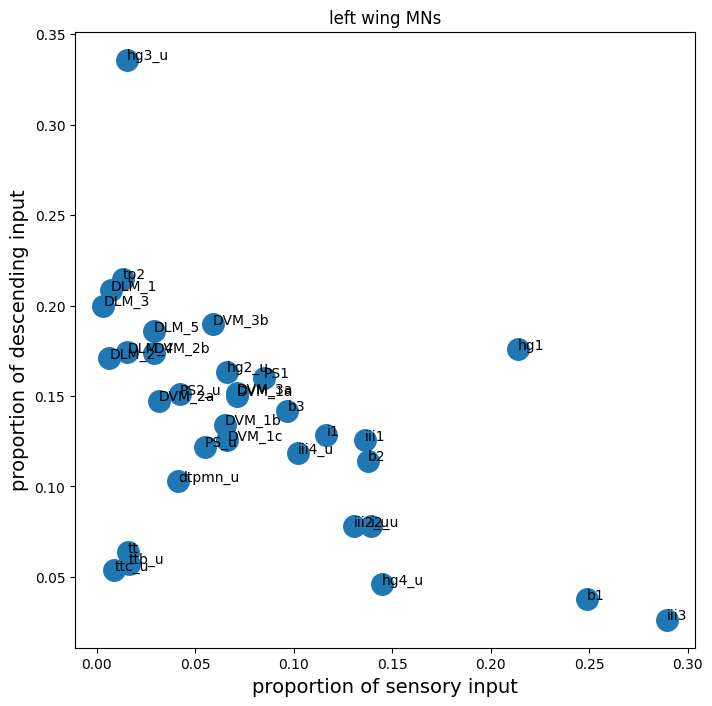

In [97]:
# xy plot of area vs volume
fig = plt.figure(1, figsize = [8,8])
plt.style.use('default')

df_plot = df

x_d = df.sen
y_s = df.desc

# x_l = np.arange(0,1e12,1000)
# y_l = x_l

labels = df.name
labels = labels.reset_index(drop=True)

ymin = -0.01
ymax = 0.25

# plt.plot(x_l,y_l, color = "black", linewidth=.5)
plt.scatter(x_d,y_s, s = 240)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x_d[i], y_s[i]))
    

# plt.ylim(ymin,ymax)
# plt.xlim(ymin,ymax)
plt.ylabel('proportion of descending input', size = 14)
plt.xlabel('proportion of sensory input', size = 14)
plt.title('left wing MNs')
# plt.yticks(np.arange(0, ymax+0.1, .1))
# plt.xticks(np.arange(0, ymax+0.1, .1))
# ax.set_xticks([0,0.25])
# plt.box(on = None)
# plt.savefig('SenseVsDesc.svg', format='svg', bbox_inches='tight')


plt.show()

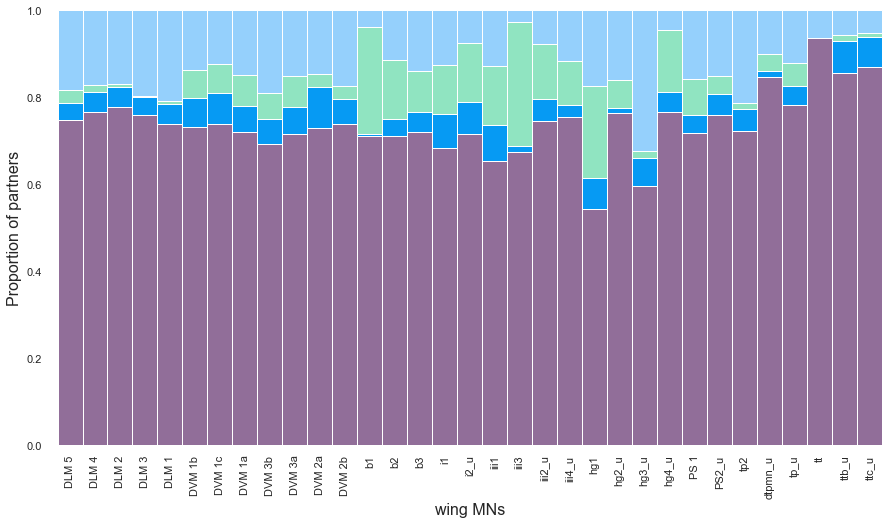

In [150]:
colors = ["#916e99","#069af3","#90e4c1","#95d0fc","#929591", "#650021"] #"#d1b26f"
cmap = sns.set_palette(sns.color_palette(colors))
df = partners_proportion_df

#create stacked bar chart
p = df.set_index('description').plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap, figsize=(15, 8)) 

p.set_ylabel("Proportion of partners",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)

# plt.axhline(0.8)
# plt.axhline(0.85)
# plt.axhline(0.9)

plt.savefig('partnerProportions.eps', format='eps', bbox_inches='tight')
plt.show()


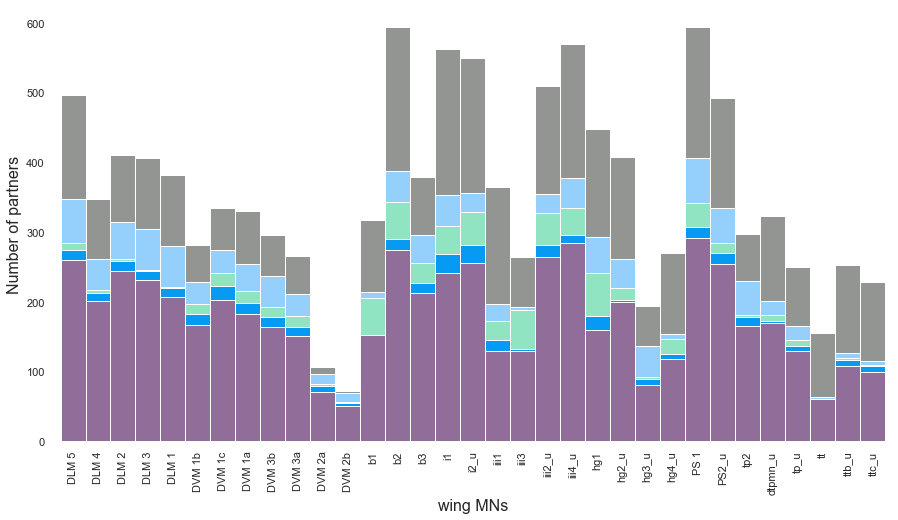

In [144]:
colors = ["#916e99","#069af3","#90e4c1","#95d0fc","#929591", "#650021"] #"#d1b26f"
cmap = sns.set_palette(sns.color_palette(colors))
df = MN_partners.iloc[:,[1,6,5,4,3,7]]

#create stacked bar chart
p = df.set_index('description').plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap, figsize=(15, 8)) 

p.set_ylabel("Number of partners",fontsize = 16)
# p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)

# plt.axhline(0.8)
# plt.axhline(0.85)
# plt.axhline(0.9)

# plt.savefig('partnerNumbers.eps', format='eps', bbox_inches='tight')
plt.show()

In [143]:
MN_partners

,SegID,description,all,desc,sen,asc,loc,frag
0,648518346472269618,DLM 5,496.0,64.0,10.0,14.0,260.0,148.0
1,648518346486629017,DLM 4,348.0,45.0,4.0,12.0,201.0,86.0
2,648518346486563887,DLM 2,411.0,53.0,2.0,15.0,244.0,97.0
3,648518346476906768,DLM 3,407.0,60.0,1.0,12.0,232.0,102.0
4,648518346515087943,DLM 1,382.0,58.0,2.0,13.0,207.0,102.0
5,648518346511825599,DVM 1b,282.0,31.0,15.0,15.0,167.0,54.0
6,648518346483122508,DVM 1c,334.0,34.0,18.0,20.0,203.0,59.0
7,648518346491784815,DVM 1a,330.0,38.0,18.0,15.0,183.0,76.0
8,648518346488827114,DVM 3b,296.0,45.0,14.0,14.0,164.0,59.0
9,648518346512153646,DVM 3a,266.0,32.0,15.0,13.0,151.0,55.0


In [98]:
# shared input to basalars
bas_syn_df = syn_df[syn_df.post_pt_root_id.isin(basalar_list)]
bas_syn_df

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,926597,t,72765817770828675,648518346475249249,72765749051266369,648518346481269135,13,"[21281, 135187, 1574]","[21261, 135161, 1574]"
1,1253344,t,73047567155762729,648518346501760329,73047567155772867,648518346481269135,19,"[29993, 143475, 740]","[29967, 143451, 741]"
2,1309468,t,72695311654860614,648518346509619242,72695311654819092,648518346481269135,17,"[18783, 132889, 1731]","[18747, 132881, 1731]"
3,2113903,t,73187686369789215,648518346497841818,73187686369789449,648518346481269135,48,"[33889, 126085, 1037]","[33919, 126107, 1037]"
5,4019514,t,74032248873446531,648518346489334361,74032248873466259,648518346481269135,48,"[57415, 130351, 1369]","[57389, 130385, 1370]"
...,...,...,...,...,...,...,...,...,...
7105,43278260,t,72906005302297699,648518346475147064,72906005302326627,648518346515574010,38,"[26507, 120357, 1287]","[26493, 120337, 1286]"
7106,43298542,t,72554573898104025,648518346499934975,72554573898116152,648518346515574010,19,"[16367, 131421, 1246]","[16367, 131451, 1245]"
7108,46029854,t,72976442698630453,648518346508758079,72976442698635617,648518346515574010,14,"[27107, 121641, 1114]","[27075, 121657, 1115]"
7109,47171770,t,72765817771039037,648518346487847703,72765817771045638,648518346515574010,35,"[22141, 136401, 1658]","[22147, 136365, 1659]"


In [118]:
# df0 = bas_syn_df[bas_syn_df.post_pt_root_id.isin([basalar_list[0]])]
df1 = bas_syn_df[bas_syn_df.post_pt_root_id.isin([basalar_list[1]])]
df2 = bas_syn_df[bas_syn_df.post_pt_root_id.isin([basalar_list[2]])]
df3 = bas_syn_df[bas_syn_df.post_pt_root_id.isin([basalar_list[0]])]

dfiii2 = syn_df[syn_df.post_pt_root_id.isin([648518346482131604])]
# df4 = DLM_syn_df[DLM_syn_df.post_pt_root_id.isin([DLM_list[4]])]

dfhg1 = syn_df[syn_df]

dfhg234

dfi1i2

In [104]:
basalar_list

[648518346515574010, 648518346481269135, 648518346493634040]

In [121]:
set1 = set(df1.pre_pt_root_id)
set2 = set(df2.pre_pt_root_id)
set3 = set(df3.pre_pt_root_id)
setiii2 = set(dfiii2.pre_pt_root_id)
# set3 = set(df3.pre_pt_root_id)
# set4 = set(df4.pre_pt_root_id)

In [109]:
int12 = set1.intersection(set2)
int123 = int12.intersection(set3)
# t = t.intersection(set3)
# t = t.intersection(set4)
# t
len(int123)

72

In [112]:
b3_syn_df_ix = df3[df3.pre_pt_root_id.isin(int123)]
b3_syn_df_ix

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
5,2533230,t,72977061241007010,648518346491516990,72977061241007043,648518346515574010,43,"[27335, 139515, 1221]","[27339, 139547, 1221]"
9,4212957,t,72836186515178008,648518346495929034,72836186515178095,648518346515574010,20,"[22531, 136473, 1663]","[22563, 136477, 1663]"
12,5999497,t,73047429850835647,648518346524038917,73047429850852315,648518346515574010,44,"[29231, 141071, 919]","[29269, 141083, 919]"
13,6618398,t,73188098821106404,648518346479095996,73188098821108649,648518346515574010,31,"[32859, 138983, 1349]","[32829, 138979, 1349]"
14,6827217,t,72836117862824236,648518346491433790,72836117862862649,648518346515574010,15,"[24087, 133625, 1800]","[24097, 133603, 1799]"
...,...,...,...,...,...,...,...,...,...
7098,39332479,t,72906692496875653,648518346487897168,72906692496851476,648518346515574010,44,"[26233, 139821, 1234]","[26257, 139863, 1234]"
7099,40017672,t,73047017668338312,648518346492651451,73047017668333445,648518346515574010,23,"[29727, 128819, 1235]","[29705, 128803, 1234]"
7106,43298542,t,72554573898104025,648518346499934975,72554573898116152,648518346515574010,19,"[16367, 131421, 1246]","[16367, 131451, 1245]"
7108,46029854,t,72976442698630453,648518346508758079,72976442698635617,648518346515574010,14,"[27107, 121641, 1114]","[27075, 121657, 1115]"


In [122]:
b3iii2_ix = df3[df3.pre_pt_root_id.isin(setiii2)]
len(b3iii2_ix) / len(df3)

0.7291111459476407

In [114]:
len(b3_syn_df_ix) / len(df3)

0.2511365417777081

In [89]:
len(t)

194

In [91]:
DVM_syn_df = syn_df[syn_df.post_pt_root_id.isin(DVM_list)]

In [94]:
t2 = t.intersection(set(DVM_syn_df.pre_pt_root_id))
len(t2)

124

In [95]:
DLMDLVM_syn_df = DLM_syn_df_ix[DLM_syn_df_ix.pre_pt_root_id.isin(t2)]
DLMDLVM_syn_df

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,31852,t,73257986260528297,648518346491967762,73257986260525813,648518346472269618,43,"[35377, 123241, 806]","[35347, 123219, 807]"
1,84072,t,72765473837991611,648518346483217060,72765473837996370,648518346472269618,151,"[20547, 125753, 981]","[20549, 125727, 981]"
2,635850,t,73187686235511928,648518346486616781,73187686235506932,648518346472269618,38,"[34431, 124997, 779]","[34407, 124979, 778]"
3,1391063,t,73117180119802874,648518346511177781,73117180119823066,648518346472269618,88,"[32703, 122233, 922]","[32691, 122279, 922]"
4,1757316,t,72976648722924867,648518346494104311,72976648722943352,648518346472269618,14,"[27847, 126989, 869]","[27853, 127011, 871]"
...,...,...,...,...,...,...,...,...,...
8030,39236989,t,73328355004662222,648518346479342290,73328423724140580,648518346515087943,50,"[37449, 124901, 796]","[37439, 124943, 796]"
8032,40443419,t,73609761463195704,648518346494104311,73609761463177041,648518346515087943,49,"[47073, 122499, 1170]","[47069, 122481, 1171]"
8033,41114663,t,73398723815907923,648518346490882081,73398723815931567,648518346515087943,38,"[39617, 123713, 919]","[39643, 123731, 919]"
8035,42628670,t,73046811375621170,648518346480133030,73046811375564538,648518346515087943,16,"[29207, 122673, 916]","[29239, 122685, 916]"


In [96]:
24208/30454

0.7949037893215998

In [109]:
nonDLM_syn_df = syn_df[~syn_df.post_pt_root_id.isin(DLM_list + DVM_list + PS_list + tp_list + tt_list)]

In [110]:
t3 = t.intersection(set(nonDLM_syn_df.pre_pt_root_id))

In [111]:
len(t3)

77

In [115]:
DLM_syn_df[DLM_syn_df.pre_pt_root_id.isin(t3)]

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
2,635850,t,73187686235511928,648518346486616781,73187686235506932,648518346472269618,38,"[34431, 124997, 779]","[34407, 124979, 778]"
8,3796986,t,72976442631245245,648518346494400277,72976442631374568,648518346472269618,54,"[27175, 122713, 912]","[27143, 122735, 911]"
9,3797266,t,72976442631429524,648518346483139774,72976442631414254,648518346472269618,35,"[27481, 122133, 937]","[27449, 122155, 938]"
13,6422273,t,73046948747640954,648518346502325587,73046948747640965,648518346472269618,20,"[29197, 126813, 871]","[29233, 126815, 871]"
15,6794261,t,73117523515977164,648518346486260128,73117523515987146,648518346472269618,48,"[31779, 132727, 601]","[31815, 132719, 602]"
...,...,...,...,...,...,...,...,...,...
8031,40191045,t,73328492510800458,648518346500936470,73328492510827658,648518346515087943,23,"[38527, 127385, 962]","[38563, 127393, 961]"
8033,41114663,t,73398723815907923,648518346490882081,73398723815931567,648518346515087943,38,"[39617, 123713, 919]","[39643, 123731, 919]"
8035,42628670,t,73046811375621170,648518346480133030,73046811375564538,648518346515087943,16,"[29207, 122673, 916]","[29239, 122685, 916]"
8036,44765369,t,73328286419409563,648518346518572767,73328286419391888,648518346515087943,54,"[38037, 122249, 1057]","[38019, 122223, 1056]"


In [116]:
nonDLM_syn_df[nonDLM_syn_df.pre_pt_root_id.isin(t3)].post_pt_root_id.value_counts()

648518346493634040    741
648518346509604297    646
648518346499823171    466
648518346487480490    448
648518346482131604    418
648518346491616529    407
648518346494407701    387
648518346498479344    341
648518346481269135    234
648518346481779133    231
648518346492048172    169
648518346499256923    130
648518346491984914     91
Name: post_pt_root_id, dtype: int64

In [113]:
12882/36973

0.348416411976307

In [60]:
# sim_mat_all = sim_mat.copy()
# sim_mat_desc = sim_mat.copy()
# sim_mat_sensory = sim_mat.copy()
# sim_mat_asc = sim_mat.copy()
# sim_mat_local = sim_mat.copy()
# sim_mat_noDesc = sim_mat.copy()
sim_mat_noLoc = sim_mat.copy()



In [79]:
df1

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
0,32126,t,73257986260619615,648518346483084708,73257986260612426,648518346486563887,35,"[35789, 123499, 850]","[35789, 123479, 849]"
1,38963,t,73469298584304046,648518346494726315,73469298584273025,648518346486563887,49,"[41149, 130181, 671]","[41115, 130163, 673]"
2,132507,t,73328286486550687,648518346494104311,73328286486553217,648518346486563887,22,"[37525, 122369, 1201]","[37551, 122403, 1201]"
4,1841248,t,72906073820096931,648518346509087354,72906073820116507,648518346486563887,37,"[26127, 122731, 789]","[26117, 122721, 791]"
5,4622195,t,72976442497364917,648518346524103941,72976442497385843,648518346486563887,42,"[28627, 122609, 763]","[28633, 122577, 764]"
...,...,...,...,...,...,...,...,...,...
8381,45807415,t,73257711516895095,648518346497841818,73257711516897662,648518346486563887,36,"[35931, 115615, 1110]","[35897, 115605, 1111]"
8382,47263505,t,73187617516555751,648518346511922879,73187617516550906,648518346486563887,30,"[32919, 123851, 895]","[32881, 123837, 896]"
8383,47387013,t,72976442564344267,648518346492959152,72976442564363219,648518346486563887,29,"[27507, 122469, 814]","[27521, 122439, 816]"
8384,47394754,t,73117454863700292,648518346517386564,73117454863674911,648518346486563887,28,"[32625, 130367, 759]","[32619, 130335, 758]"


In [205]:
# conn matrix of desc onto local by preferred motor pool

# desc_df = ut.build_synapse_df(descending_df.SegID.to_list(),"post",3,client) 
temp_counts = pd.DataFrame(desc_df['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

if temp_counts.shape[0] != len(descending_df.SegID.to_list()):
    print('Warning: The following segIDs are not up to date')
    print(list(set(descending_df.SegID.to_list()) - set(temp_counts['SegID'])))


In [225]:
desc_pmn_syn = desc_df[desc_df.post_pt_root_id.isin(local_df.SegID.to_list())]
len(desc_pmn_syn)

70303

In [207]:
desc_pmn_syn.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position
7,1391028,t,73117180120073618,648518346489570655,73117180120053026,648518346517261093,18,"[32527, 122325, 1014]","[32547, 122353, 1014]"
9,2111630,t,73258261205604025,648518346489570655,73258261205608814,648518346488572344,36,"[36407, 132285, 967]","[36433, 132313, 967]"
13,3113002,t,73680611243533412,648518346489570655,73680611243675672,648518346491561640,13,"[48917, 136419, 1163]","[48913, 136383, 1165]"
30,12246751,t,73258329991860721,648518346489570655,73258329992029582,648518346496648756,59,"[36519, 133897, 1038]","[36551, 133889, 1038]"
34,12634583,t,73187068163218864,648518346489570655,73187068163202045,648518346459596548,44,"[33309, 107587, 1601]","[33293, 107553, 1601]"


In [226]:
desc_pmn_syn = desc_pmn_syn.merge(proportion_df.rename(columns ={"SegID": "post_pt_root_id"})[["post_pt_root_id","pref"]],how = 'inner')

In [227]:
adj = pd.crosstab(desc_pmn_syn.pre_pt_root_id,desc_pmn_syn.pref)

<AxesSubplot:xlabel='pref', ylabel='pre_pt_root_id'>

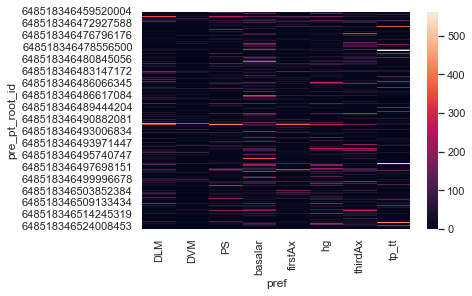

In [228]:
sns.heatmap(adj)

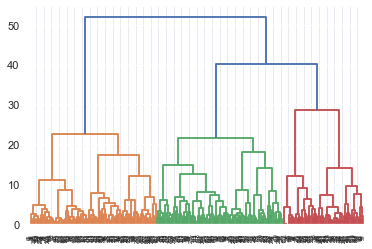

In [229]:
sim_mat_temp = cosine_similarity(adj.to_numpy())
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
reordered_df = adj.iloc[clustered_order,:]
sim_mat = cosine_similarity(reordered_df.to_numpy())

In [ ]:
fig = plt.figure(1, figsize = [7,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense
# cmap = plt.set_cmap("rocket")
# adj_trunc = adj_order.transpose().iloc[18:22].transpose()
all_reorderedLOG_df = np.log10(reordered_df)
#pmn_ids = reordered_pmn_labels_df.description
ax = sns.heatmap(all_reorderedLOG_df, vmin = 0, vmax = 2.5, cmap = cmap)# , xticklabels=mn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
#plt.xticks(rotation = 90)
plt.title('wing premotor connectivity', size = 20)
#cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('pmns by preference', size = 16)
plt.ylabel('Premotor descending', size = 16)

#plt.savefig('wingConnMatrix0818.svg', format='svg', bbox_inches='tight')
# plt.savefig('wingConnMatrix0818.eps', format='eps', bbox_inches='tight')

plt.show()


In [231]:
# organize descending by their preference!
desc_pmn_syn = desc_pmn_syn.merge(proportion_df.rename(columns ={"SegID": "pre_pt_root_id", "pref":"pref_d"})[["pre_pt_root_id","pref_d"]],how = 'inner')
desc_pmn_syn.head()


,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,score,pre_pt_position,post_pt_position,pref,pref_d
0,1391028,t,73117180120073618,648518346489570655,73117180120053026,648518346517261093,18,"[32527, 122325, 1014]","[32547, 122353, 1014]",DLM,DLM
1,39856341,t,72906142472816808,648518346489570655,72906142472895677,648518346517261093,64,"[24829, 124817, 771]","[24829, 124857, 771]",DLM,DLM
2,33728066,t,72976923600787960,648518346489570655,72976923600778069,648518346517261093,13,"[26711, 136421, 860]","[26705, 136399, 862]",DLM,DLM
3,33728035,t,72976923600787960,648518346489570655,72976923600778069,648518346517261093,40,"[26685, 136443, 856]","[26673, 136409, 857]",DLM,DLM
4,1390772,t,73117180120090873,648518346489570655,73117180120066859,648518346517261093,59,"[32107, 122617, 1018]","[32103, 122651, 1018]",DLM,DLM


In [232]:
adj = pd.crosstab(desc_pmn_syn.pref_d,desc_pmn_syn.pref)

<AxesSubplot:xlabel='pref', ylabel='pref_d'>

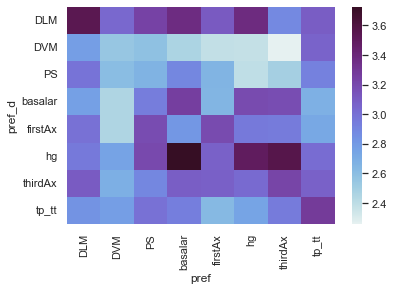

In [235]:
sns.heatmap(np.log10(adj),cmap = cmap)

In [236]:
# conn matrix of local onto local by preferred motor pool

local_syn = ut.build_synapse_df(local_df.SegID.to_list(),"post",3,client) 
temp_counts = pd.DataFrame(local_syn['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

if temp_counts.shape[0] != len(local_df.SegID.to_list()):
    print('Warning: The following segIDs are not up to date')
    print(list(set(local_df.SegID.to_list()) - set(temp_counts['SegID'])))

AttributeError: 'DataFrame' object has no attribute 'SegID'

In [240]:
local_df = premotor_df[premotor_df['class'].isin(['local'])]

In [241]:
loc_pmn_syn = local_syn[local_syn.post_pt_root_id.isin(local_df.SegID.to_list())]


In [242]:
loc_pmn_syn = loc_pmn_syn.merge(proportion_df.rename(columns ={"SegID": "post_pt_root_id"})[["post_pt_root_id","pref"]],how = 'inner')

In [243]:
loc_pmn_syn = loc_pmn_syn.merge(proportion_df.rename(columns ={"SegID": "pre_pt_root_id", "pref":"pref_L"})[["pre_pt_root_id","pref_L"]],how = 'inner')


In [244]:
adj = pd.crosstab(loc_pmn_syn.pref_L,loc_pmn_syn.pref)

<AxesSubplot:xlabel='pref', ylabel='pref_L'>

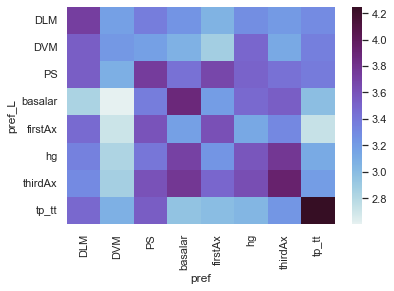

In [245]:
sns.heatmap(np.log10(adj),cmap = cmap)

In [246]:
# conn matrix of sensory onto local by preferred motor pool

sensory_syn = ut.build_synapse_df(sensory_df.SegID.to_list(),"post",3,client) 
temp_counts = pd.DataFrame(sensory_syn['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

if temp_counts.shape[0] != len(sensory_df.SegID.to_list()):
    print('Warning: The following segIDs are not up to date')
    print(list(set(sensory_df.SegID.to_list()) - set(temp_counts['SegID'])))

[]


<AxesSubplot:xlabel='pref', ylabel='pref_S'>

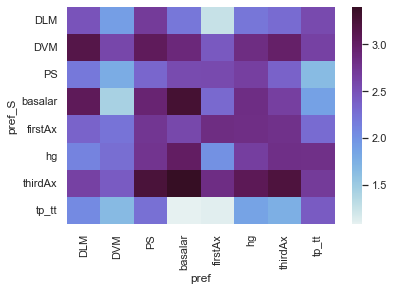

In [247]:
sen_pmn_syn = sensory_syn[sensory_syn.post_pt_root_id.isin(local_df.SegID.to_list())]
sen_pmn_syn = sen_pmn_syn.merge(proportion_df.rename(columns ={"SegID": "post_pt_root_id"})[["post_pt_root_id","pref"]],how = 'inner')
sen_pmn_syn = sen_pmn_syn.merge(proportion_df.rename(columns ={"SegID": "pre_pt_root_id", "pref":"pref_S"})[["pre_pt_root_id","pref_S"]],how = 'inner')
adj = pd.crosstab(sen_pmn_syn.pref_S,sen_pmn_syn.pref)
sns.heatmap(np.log10(adj),cmap = cmap)

In [47]:
reordered_motor_labels_df

,SegID,description
0,648518346472269618,DLM 5
1,648518346486629017,DLM 4
2,648518346486563887,DLM 2
3,648518346476906768,DLM 3
4,648518346515087943,DLM 1
5,648518346511825599,DVM 1b
6,648518346483122508,DVM 1c
7,648518346491784815,DVM 1a
8,648518346488827114,DVM 3b
9,648518346512153646,DVM 3a


In [261]:
sim_mat_df = pd.DataFrame(sim_mat, columns=[lbls], index = lbls)
# sim_mat_df[['b1','b2','i1','i2?']]
A_b1b2 = sim_mat_df.loc['b1', 'b2']
A_b1i1 = sim_mat_df.loc['b1', 'i1']
A_b1i2 = sim_mat_df.loc['b1', 'i2?']
A_b2i1 = sim_mat_df.loc['b2', 'i1']
A_b2i2 = sim_mat_df.loc['b2', 'i2?']
A_i1i2 = sim_mat_df.loc['i1', 'i2?']

In [83]:
reordered_motor_labels_df

,SegID,description,all_syn,loc_syn,asc_syn,sen_syn,desc_syn,frag_syn,other_syn,noise_syn
0,648518346472269618,DLM 5,9465,7349,250,63,1106,46,673,24
1,648518346486629017,DLM 4,6198,4934,144,19,728,38,342,31
2,648518346486563887,DLM 2,7425,5602,320,8,1048,45,430,17
3,648518346476906768,DLM 3,6557,5127,186,3,817,38,397,27
4,648518346515087943,DLM 1,7328,5577,207,11,1073,42,429,31
5,648518346511825599,DVM 1b,3352,2419,213,166,327,18,227,0
6,648518346483122508,DVM 1c,4149,3133,299,118,375,7,214,10
7,648518346491784815,DVM 1a,4908,3672,357,116,453,7,310,0
8,648518346488827114,DVM 3b,3933,2932,208,77,471,5,237,8
9,648518346512153646,DVM 3a,3869,2900,253,105,376,6,232,3


In [650]:
desccounts = pd.DataFrame(descending_syn['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='desc'))
# sensecounts = pd.DataFrame(sensory_syn['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='sense'))
# dfs = desccounts.merge(sensecounts, on = 'SegID')
dfs = desccounts.merge(postcounts, on = 'SegID')
dfs = dfs.assign(pD=lambda x: (dfs['desc'] / dfs['counts']))
# dfs = dfs.assign(pS=lambda x: (dfs['sense'] / dfs['counts']))
dfs = dfs.merge(leftMN_df, on = 'SegID')



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


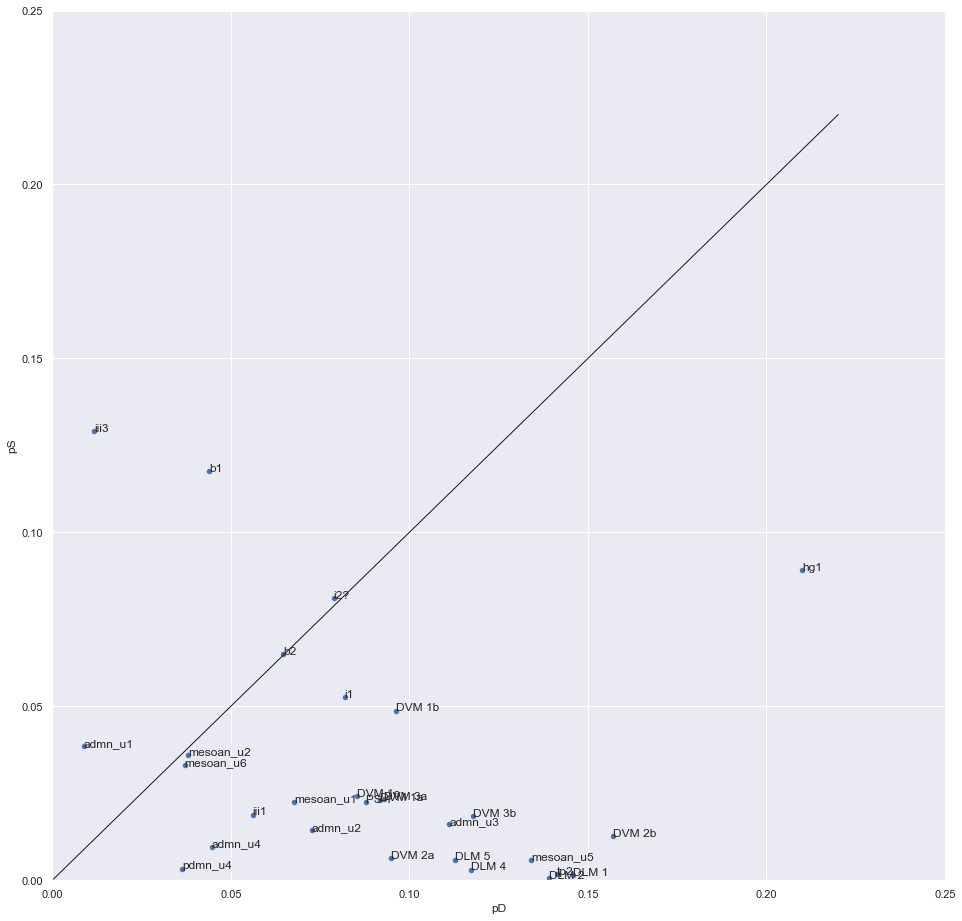

In [646]:
# sensory input by descending input
# desccounts = pd.DataFrame(descending_syn['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='desc'))
# sensecounts = pd.DataFrame(sensory_syn['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='sense'))


# dfs = desccounts.merge(sensecounts, on = 'SegID')
# dfs = dfs.merge(leftMN_df, on = 'SegID')
x = dfs.pD
y = dfs.pS
dfs.plot.scatter(x = "pD", y = "pS", figsize = (16,16))

labels = dfs.name
labels = labels.reset_index(drop=True)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]), size = 12)

xpoints = ypoints = plt.xlim()
plt.xlim(0,0.25)
plt.ylim(0,0.25)

plt.plot(xpoints, ypoints, linestyle='-', color='k', lw=1, scalex=False, scaley=False)

# plt.savefig('DxS0623.svg', format='svg', bbox_inches='tight')

plt.show()

In [64]:
pre_syn = syn_df
reordered_motor_labels_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])
frag_df = premotor_df[premotor_df['class'].isin(['fragment'])]
noise_df = premotor_df[premotor_df['class'].isin(['mn'])]


reordered_motor_labels_df['all_syn'] = ''
reordered_motor_labels_df['loc_syn'] = ''
reordered_motor_labels_df['asc_syn'] = ''
reordered_motor_labels_df['sen_syn'] = ''

reordered_motor_labels_df['desc_syn'] = ''
reordered_motor_labels_df['frag_syn'] = ''
reordered_motor_labels_df['other_syn'] = ''
reordered_motor_labels_df['noise_syn'] = ''



i = 0
while i < len(reordered_motor_labels_df):
    tempMN = reordered_motor_labels_df.SegID.iloc[i]
    temp_df = pre_syn[pre_syn['post_pt_root_id'].isin([tempMN])]
    reordered_motor_labels_df['all_syn'].iloc[i] = len(temp_df)
    
    loc_temp = temp_df[temp_df.pre_pt_root_id.isin(local_df.SegID.to_list())]
    reordered_motor_labels_df['loc_syn'].iloc[i] = len(loc_temp)
    
    asc_temp = temp_df[temp_df.pre_pt_root_id.isin(ascending_df.SegID.to_list())]
    reordered_motor_labels_df['asc_syn'].iloc[i] = len(asc_temp)
    
    sen_temp = temp_df[temp_df.pre_pt_root_id.isin(sensory_df.SegID.to_list())]
    reordered_motor_labels_df['sen_syn'].iloc[i] = len(sen_temp)

    desc_temp = temp_df[temp_df.pre_pt_root_id.isin(descending_df.SegID.to_list())]
    reordered_motor_labels_df['desc_syn'].iloc[i] = len(desc_temp)
    
    frag_temp = temp_df[temp_df.pre_pt_root_id.isin(twigIDs)]
    frag_temp2 = temp_df[temp_df.pre_pt_root_id.isin(frag_df.SegID.to_list())]
    reordered_motor_labels_df['frag_syn'].iloc[i] = len(frag_temp) + len(frag_temp2)
    
    noise_temp = temp_df[temp_df.pre_pt_root_id.isin(noise_df.SegID.to_list())]
    reordered_motor_labels_df['noise_syn'].iloc[i] = len(noise_temp)
    
    reordered_motor_labels_df['other_syn'].iloc[i] = len(temp_df) - (len(desc_temp) +  len(sen_temp) + len(loc_temp) + len(asc_temp) + len(frag_temp) + len(noise_temp))
    
    i = i+1

reordered_motor_labels_df


/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,SegID,description,all_syn,loc_syn,asc_syn,sen_syn,desc_syn,frag_syn,other_syn,noise_syn
0,648518346472269618,DLM 5,9465,7339,250,63,1106,46,683,24
1,648518346486629017,DLM 4,6198,4931,144,19,728,38,345,31
2,648518346486563887,DLM 2,7425,5597,320,8,1048,45,435,17
3,648518346476906768,DLM 3,6557,5127,186,3,817,38,397,27
4,648518346515087943,DLM 1,7328,5572,207,11,1073,42,434,31
5,648518346511825599,DVM 1b,3352,2419,213,166,327,18,227,0
6,648518346483122508,DVM 1c,4151,3135,299,115,375,7,217,10
7,648518346491784815,DVM 1a,4908,3672,357,116,453,7,310,0
8,648518346488827114,DVM 3b,3933,2932,208,77,471,5,237,8
9,648518346512153646,DVM 3a,3869,2900,253,105,376,6,232,3


In [ ]:
# proportion df
proportion_df = reordered_motor_labels_df.iloc[:,1:2]
proportion_df['loc'] = reordered_motor_labels_df.loc_syn / reordered_motor_labels_df.all_syn
proportion_df['asc'] = reordered_motor_labels_df.asc_syn / reordered_motor_labels_df.all_syn
proportion_df['sen'] = reordered_motor_labels_df.sen_syn / reordered_motor_labels_df.all_syn

proportion_df['desc'] = reordered_motor_labels_df.desc_syn / reordered_motor_labels_df.all_syn
proportion_df['frag'] = reordered_motor_labels_df.frag_syn / reordered_motor_labels_df.all_syn
proportion_df['other'] = reordered_motor_labels_df.other_syn / reordered_motor_labels_df.all_syn
proportion_df['noise'] = reordered_motor_labels_df.noise_syn / reordered_motor_labels_df.all_syn

proportion_df

In [69]:
proportion_df

,description,loc,asc,sen,desc,frag,other,noise
0,DLM 5,0.775383,0.026413,0.006656,0.116852,0.00486,0.072161,0.002536
1,DLM 4,0.795579,0.023233,0.003066,0.117457,0.006131,0.055663,0.005002
2,DLM 2,0.753805,0.043098,0.001077,0.141145,0.006061,0.058586,0.00229
3,DLM 3,0.781912,0.028367,0.000458,0.1246,0.005795,0.060546,0.004118
4,DLM 1,0.760371,0.028248,0.001501,0.146425,0.005731,0.059225,0.00423
5,DVM 1b,0.721659,0.063544,0.049523,0.097554,0.00537,0.067721,0.0
6,DVM 1c,0.75524,0.072031,0.027704,0.09034,0.001686,0.052277,0.002409
7,DVM 1a,0.748166,0.072738,0.023635,0.092298,0.001426,0.063162,0.0
8,DVM 3b,0.745487,0.052886,0.019578,0.119756,0.001271,0.060259,0.002034
9,DVM 3a,0.749548,0.065392,0.027139,0.097183,0.001551,0.059964,0.000775


In [75]:
proportion_df[0:12].sen.mean()

0.0152016427395296

In [66]:

#colors = ["#95d0fc","#90e4c1","#916e99","#069af3","#d1b26f","#929591"]

colors = ["#916e99","#069af3","#90e4c1","#95d0fc","#d1b26f","#929591", "#650021"]


cmap = sns.set_palette(sns.color_palette(colors))

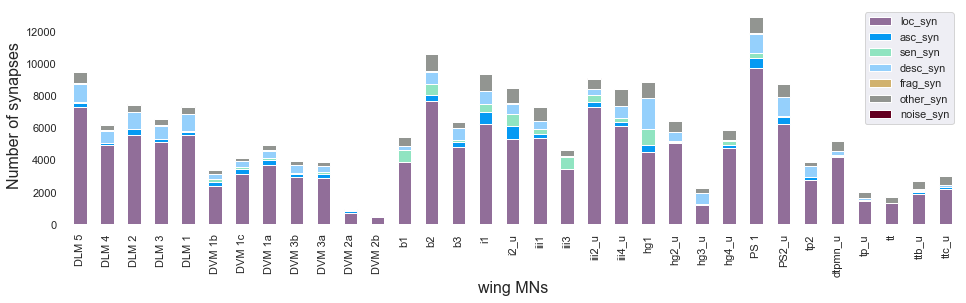

In [67]:
# bar chart of fractional inputs
#sns.set(style='white')
#sns.set_color_codes("muted")
#plt.figure(1, figsize = [8,1])
## 6/9/22


cmap = sns.set_palette(sns.color_palette(colors))
df = reordered_motor_labels_df.drop(columns = ['all_syn','SegID'])#proportion_df

#create stacked bar chart
p = df.set_index('description').plot(kind='bar', stacked=True, width = .5, legend = True, cmap = cmap, figsize=(16, 4)) 

p.set_ylabel("Number of synapses", fontsize = 16)
#p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)

# plt.savefig('wingMNinputs.svg', format='svg', bbox_inches='tight')
plt.show()

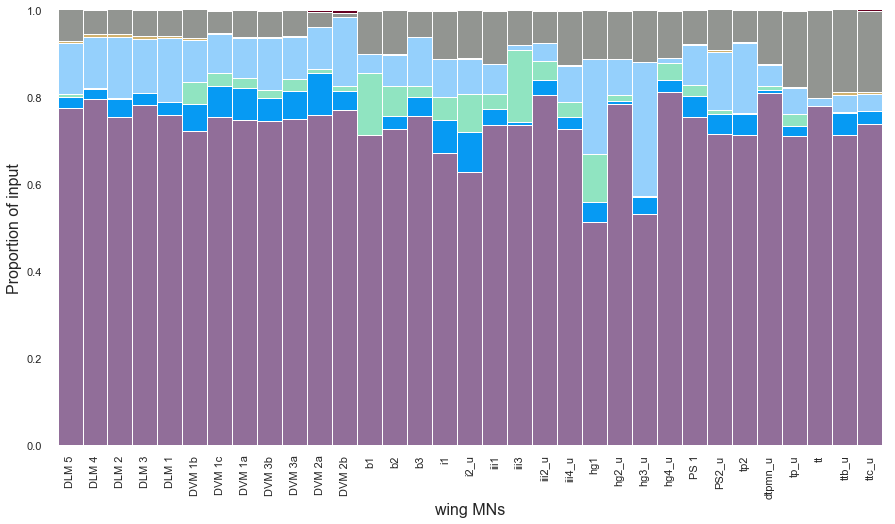

In [68]:
cmap = sns.set_palette(sns.color_palette(colors))
df = proportion_df

#create stacked bar chart
p = df.set_index('description').plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap, figsize=(15, 8)) 

p.set_ylabel("Proportion of input",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)

# plt.axhline(0.8)
# plt.axhline(0.85)
# plt.axhline(0.9)

# plt.savefig('wingProportions.eps', format='eps', bbox_inches='tight')
plt.show()


In [119]:
local_df.head()

,Unnamed: 0,SegID,counts,class,cell_type,notes1
398,1207,648518346459413252,34.0,local,3B,3B t2
399,789,648518346459550468,65.0,local,3B,3Ba t1
400,591,648518346459573508,91.0,local,12A,12A t2
401,1349,648518346459589380,28.0,local,11B,11B t2
402,1208,648518346459591428,34.0,local,3A,3A?


In [120]:
# local input proportions by predicted NT
# NT lists - according to Lacin et al 2019
ACh_list = ['1A', '3A', '4B', '7B', '8B', '10B', '11A', '12A', '17A', '18B', '19B', '20A', '22A', '23B', 'PSI']
GABA_list = ['0', '1B', '3B', '5B', '6A', '6B', '9A', '11B', '12B', '13A', '13B', '19A'] 
Glu_list = ['2A', '8A', '14A', '15B', '16B', '21A', '24B']

# local_u_df = local_df[local_df.#local uncertain

ACh_df = local_df[local_df.cell_type.isin(ACh_list)]
GABA_df = local_df[local_df.cell_type.isin(GABA_list)]
Glu_df = local_df[local_df.cell_type.isin(Glu_list)]
Other_pmn_df = local_df[~local_df.cell_type.isin(ACh_list + GABA_list + Glu_list)]


In [118]:
pre_syn = syn_df[syn_df.pre_pt_root_id.isin(local_df.SegID.to_list())]
NTmn_df =  pd.DataFrame(reordered_MN_dict.items(), columns=['SegID', 'description'])

NTmn_df['loc_syn'] = ''
NTmn_df['ACh_syn'] = ''
NTmn_df['Other_syn'] = ''
NTmn_df['Glu_syn'] = ''
NTmn_df['GABA_syn'] = ''

i = 0
while i < len(NTmn_df):
    tempMN = NTmn_df.SegID.iloc[i]
    temp_df = pre_syn[pre_syn['post_pt_root_id'].isin([tempMN])]
    NTmn_df['loc_syn'].iloc[i] = len(temp_df)
    
    ach_temp = temp_df[temp_df.pre_pt_root_id.isin(ACh_df.SegID.to_list())]
    NTmn_df['ACh_syn'].iloc[i] = len(ach_temp)
    
    oth_temp = temp_df[temp_df.pre_pt_root_id.isin(Other_pmn_df.SegID.to_list())]
    NTmn_df['Other_syn'].iloc[i] = len(oth_temp)
    
    glu_temp = temp_df[temp_df.pre_pt_root_id.isin(Glu_df.SegID.to_list())]
    NTmn_df['Glu_syn'].iloc[i] = len(glu_temp)

    gaba_temp = temp_df[temp_df.pre_pt_root_id.isin(GABA_df.SegID.to_list())]
    NTmn_df['GABA_syn'].iloc[i] = len(gaba_temp)
    
    i = i+1

NTmn_df


/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NameError: name 'ACh_df' is not defined

In [98]:
# proportion df
NTproportion_df = NTmn_df.iloc[:,1:2]
NTproportion_df['ach'] = NTmn_df.ACh_syn / NTmn_df.loc_syn
NTproportion_df['oth'] = NTmn_df.Other_syn / NTmn_df.loc_syn
NTproportion_df['glu'] = NTmn_df.Glu_syn / NTmn_df.loc_syn
NTproportion_df['gaba'] = NTmn_df.GABA_syn / NTmn_df.loc_syn

NTproportion_df

/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying t

,description,ach,oth,glu,gaba
0,DLM 5,0.67152,0.034154,0.013879,0.280446
1,DLM 4,0.687475,0.026753,0.018646,0.267126
2,DLM 2,0.713138,0.026955,0.015173,0.244734
3,DLM 3,0.676614,0.027501,0.01931,0.276575
4,DLM 1,0.715618,0.024027,0.014703,0.245652
5,DVM 1b,0.70277,0.021496,0.002067,0.273667
6,DVM 1c,0.738589,0.053304,0.001915,0.206192
7,DVM 1a,0.734205,0.033497,0.001089,0.231209
8,DVM 3b,0.594134,0.03206,0.001705,0.372101
9,DVM 3a,0.608966,0.02931,0.0,0.361724


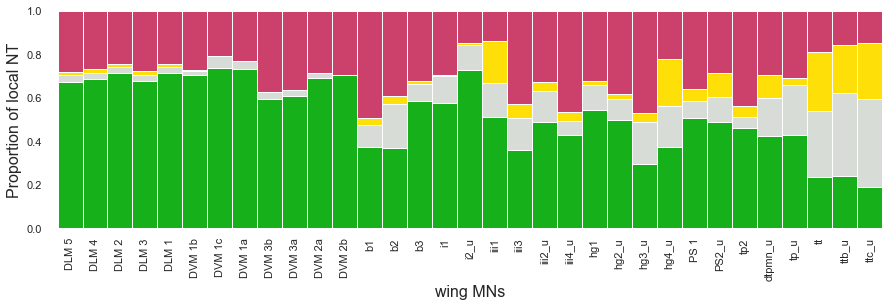

In [102]:
# colors_NT = ["#15b01a","#96f97b", "#d8dcd6", "#fdee73", "#fedf08","#f7879a","#cb416b"]
colors_NT = ["#15b01a", "#d8dcd6", "#fedf08","#cb416b"] # no uncertain colors


cmap = sns.set_palette(sns.color_palette(colors_NT))
df = NTproportion_df

#create stacked bar chart
p = df.set_index('description').plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap, figsize=(15, 4)) 

p.set_ylabel("Proportion of local NT",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)
# plt.axhline(0.5)


plt.savefig('NTProportions.eps', format='eps', bbox_inches='tight')
plt.show()


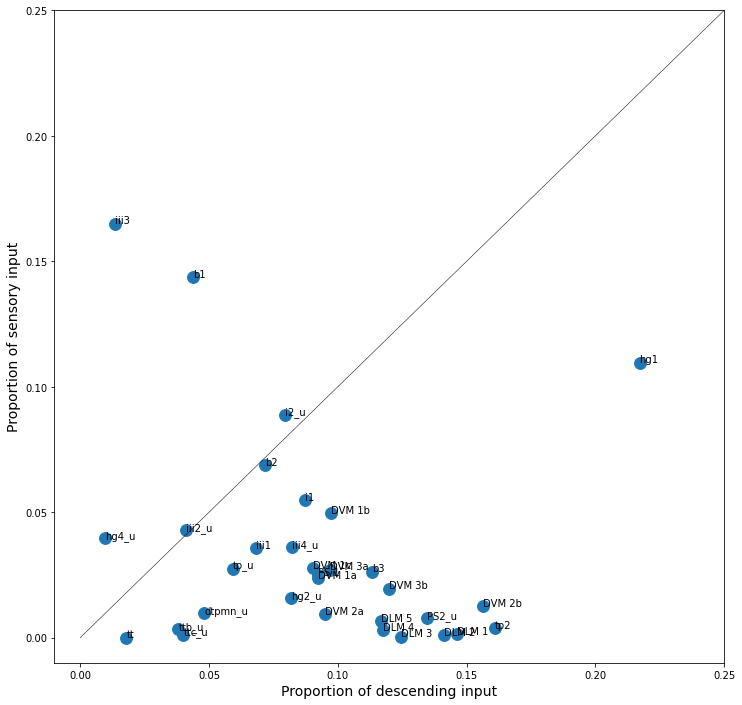

In [311]:
#xy plot against each other
fig = plt.figure(1, figsize = [12,12])
plt.style.use('default')

df = proportion_df

x_d = df.desc
y_s = df.sen

x_l = np.arange(0,1,0.1)
y_l = x_l

labels = df.description
labels = labels.reset_index(drop=True)

ymin = -0.01
ymax = 0.25

plt.plot(x_l,y_l, color = "black", linewidth=.5)
plt.scatter(x_d,y_s, s = 140)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x_d[i], y_s[i]))
    

plt.ylim(ymin,ymax)
plt.xlim(ymin,ymax)
plt.xlabel('Proportion of descending input', size = 14)
plt.ylabel('Proportion of sensory input', size = 14)
# plt.yticks(np.arange(0, ymax+0.1, .1))
# plt.xticks(np.arange(0, ymax+0.1, .1))
ax.set_xticks([0,0.25])
# plt.box(on = None)
# plt.savefig('descVsSense.svg', format='svg', bbox_inches='tight')


plt.show()

In [312]:
MN_info = pd.read_csv('leftMN_measurements.csv')

In [315]:
df['name'] = df['description']
df

/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,description,loc,asc,sen,desc,frag,other,noise,name
0,DLM 5,0.775383,0.026413,0.006656,0.116852,0.00486,0.072161,0.002536,DLM 5
1,DLM 4,0.795579,0.023233,0.003066,0.117457,0.006131,0.055663,0.005002,DLM 4
2,DLM 2,0.753805,0.043098,0.001077,0.141145,0.006061,0.058586,0.00229,DLM 2
3,DLM 3,0.781912,0.028367,0.000458,0.1246,0.005795,0.060546,0.004118,DLM 3
4,DLM 1,0.760371,0.028248,0.001501,0.146425,0.005731,0.059225,0.00423,DLM 1
5,DVM 1b,0.721659,0.063544,0.049523,0.097554,0.00537,0.067721,0.0,DVM 1b
6,DVM 1c,0.75524,0.072031,0.027704,0.09034,0.001686,0.052277,0.002409,DVM 1c
7,DVM 1a,0.748166,0.072738,0.023635,0.092298,0.001426,0.063162,0.0,DVM 1a
8,DVM 3b,0.745487,0.052886,0.019578,0.119756,0.001271,0.060259,0.002034,DVM 3b
9,DVM 3a,0.749548,0.065392,0.027139,0.097183,0.001551,0.059964,0.000775,DVM 3a


In [318]:
df.merge(MN_info, on = 'name', how = 'left')

,description,loc,asc,sen,desc,frag,other,noise,name,Unnamed: 0,vol_um,area_um,SegID,tot_syn,n_prepart,Dmax,Dmin,AxArea_um,sc_order,ax_perim
0,DLM 5,0.775383,0.026413,0.006656,0.116852,0.00486,0.072161,0.002536,DLM 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DLM 4,0.795579,0.023233,0.003066,0.117457,0.006131,0.055663,0.005002,DLM 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DLM 2,0.753805,0.043098,0.001077,0.141145,0.006061,0.058586,0.00229,DLM 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DLM 3,0.781912,0.028367,0.000458,0.1246,0.005795,0.060546,0.004118,DLM 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DLM 1,0.760371,0.028248,0.001501,0.146425,0.005731,0.059225,0.00423,DLM 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,DVM 1b,0.721659,0.063544,0.049523,0.097554,0.00537,0.067721,0.0,DVM 1b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,DVM 1c,0.75524,0.072031,0.027704,0.09034,0.001686,0.052277,0.002409,DVM 1c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DVM 1a,0.748166,0.072738,0.023635,0.092298,0.001426,0.063162,0.0,DVM 1a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,DVM 3b,0.745487,0.052886,0.019578,0.119756,0.001271,0.060259,0.002034,DVM 3b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,DVM 3a,0.749548,0.065392,0.027139,0.097183,0.001551,0.059964,0.000775,DVM 3a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#xy plot against each other
fig = plt.figure(1, figsize = [12,12])
plt.style.use('default')

df = proportion_df

x_d = df.desc
y_s = df.sen

x_l = np.arange(0,1,0.1)
y_l = x_l

labels = df.description
labels = labels.reset_index(drop=True)

ymin = -0.01
ymax = 0.25

plt.plot(x_l,y_l, color = "black", linewidth=.5)
plt.scatter(x_d,y_s, s = 140)

for i, txt in enumerate(labels):
    plt.annotate(txt, (x_d[i], y_s[i]))
    

plt.ylim(ymin,ymax)
plt.xlim(ymin,ymax)
plt.xlabel('Proportion of descending input', size = 14)
plt.ylabel('Proportion of sensory input', size = 14)
# plt.yticks(np.arange(0, ymax+0.1, .1))
# plt.xticks(np.arange(0, ymax+0.1, .1))
ax.set_xticks([0,0.25])
# plt.box(on = None)
# plt.savefig('descVsSense.svg', format='svg', bbox_inches='tight')


plt.show()

In [125]:
render_synapses = synapse_df[50000:51000]


from nglui.statebuilder import *

img_source = client.info.image_source()
img_layer = ImageLayerConfig(name='fanc_v4',
                             source=img_source,
                             )
seg_source = client.info.segmentation_source()

# seg_layer = SegmentationLayerConfig(name = 'seg',
#                                     source = seg_source,
#                                     fixed_ids = render_neurons)
points = PointMapper(point_column='post_pt_position') ######################## change this to toggle rendering of pre- or post- synaptic points
anno_layer = AnnotationLayerConfig(name='annos',
                                   mapping_rules=points )

# sb = StateBuilder([img_layer, seg_layer, anno_layer], resolution=[4.3,4.3,45])
sb = StateBuilder([img_layer, anno_layer], resolution=[4.3,4.3,45])

sb.render_state(render_synapses, return_as='html')

In [118]:
len(synapse_df)

184385

In [16]:
# shuffle numbers around within a column, replace in larger matrix, find cosine similarity
def resample_with_replacement(x):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """

  # Get array of indices for resampled points
  sample_idx = np.random.choice(len(x), size=len(x), replace=True)

  # Sample from x and y according to sample_idx
  x_ = x[sample_idx]
#   y_ = y[sample_idx]

  return x_

/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The pa

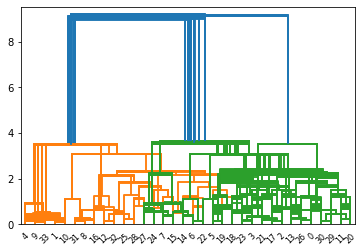

In [157]:
num_shuffles = 1000
j = 0
b1b2 = np.empty(num_shuffles)
b1i1 = np.empty(num_shuffles)
b1i2 = np.empty(num_shuffles)
b2i1 = np.empty(num_shuffles)
b2i2 = np.empty(num_shuffles)
i1i2 = np.empty(num_shuffles)

while j < num_shuffles:

    i = 0
    # shuffled_adj = pd.DataFrame(pd.np.empty((adj.shape[0], adj.shape[1])))
    shuffled_adj_17A = pd.DataFrame(pd.np.empty((adj_17A.shape[0], adj_17A.shape[1])))
    while i < adj_17A.shape[1]:
        x = np.array(adj_17A.iloc[:,i])
        x_ = resample_with_replacement(x)
        shuffled_adj_17A.iloc[:,i] = x_

        # x = np.array(adj.iloc[:,i])
        # x_ = resample_with_replacement(x)
        # shuffled_adj.iloc[:,i] = x_


        i = i +1

    adj_temp = shuffled_adj_17A.merge(adj_not_17A, how = 'outer')
    # adj_temp = shuffled_adj

    sim_mat_temp = cosine_similarity(adj_temp.to_numpy().transpose())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj_temp.iloc[:,clustered_order]
    shuffled_sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())

    shuffled_sim_mat_df = pd.DataFrame(shuffled_sim_mat, columns=[lbls], index = lbls)

    b1b2[j] = shuffled_sim_mat_df.loc['b1', 'b2']
    b1i1[j] = shuffled_sim_mat_df.loc['b1', 'i1']
    b1i2[j] = shuffled_sim_mat_df.loc['b1', 'i2?']
    b2i1[j] = shuffled_sim_mat_df.loc['b2', 'i1']
    b2i2[j] = shuffled_sim_mat_df.loc['b2', 'i2?']
    i1i2[j] = shuffled_sim_mat_df.loc['i1', 'i2?']

    j = j +1



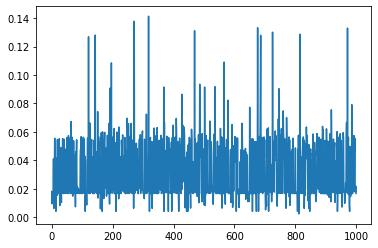

In [168]:
plt.plot(b2i1)

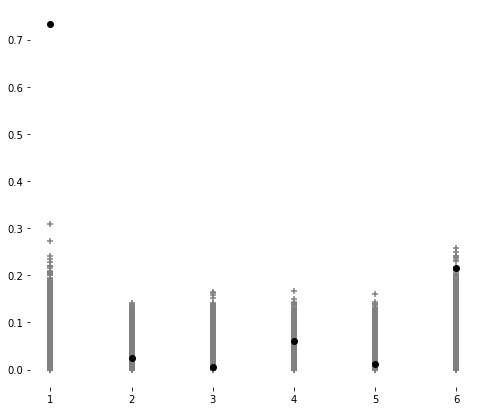

In [185]:
fig = plt.figure(1, figsize = [8,7])

x = np.ones(num_shuffles)

plt.scatter(x,all_b1b2, marker='+', color = "grey")
plt.scatter(x*2,all_b1i1, marker='+', color = "grey")
plt.scatter(x*3,all_b1i2, marker='+', color = "grey")
plt.scatter(x*4,all_b2i1, marker='+', color = "grey")
plt.scatter(x*5,all_b2i2, marker='+', color = "grey")
plt.scatter(x*6,all_i1i2, marker='+', color = "grey")



plt.scatter(1,trueb1b2, marker='o', color = "black")
plt.scatter(2,trueb1i1, marker='o', color = "black")
plt.scatter(3,trueb1i2, marker='o', color = "black")
plt.scatter(4,trueb2i1, marker='o', color = "black")
plt.scatter(5,trueb2i2, marker='o', color = "black")
plt.scatter(6,truei1i2, marker='o', color = "black")



plt.box(False)
plt.show()

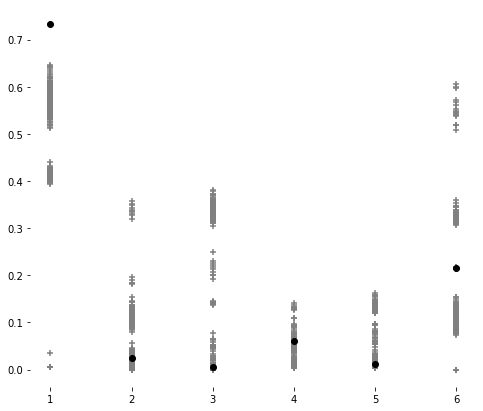

In [192]:
fig = plt.figure(1, figsize = [8,7])

x = np.ones(num_shuffles)

plt.scatter(x,b1b2, marker='+', color = "grey")
plt.scatter(x*2,b1i1, marker='+', color = "grey")
plt.scatter(x*3,b1i2, marker='+', color = "grey")
plt.scatter(x*4,b2i1, marker='+', color = "grey")
plt.scatter(x*5,b2i2, marker='+', color = "grey")
plt.scatter(x*6,i1i2, marker='+', color = "grey")



plt.scatter(1,trueb1b2, marker='o', color = "black")
plt.scatter(2,trueb1i1, marker='o', color = "black")
plt.scatter(3,trueb1i2, marker='o', color = "black")
plt.scatter(4,trueb2i1, marker='o', color = "black")
plt.scatter(5,trueb2i2, marker='o', color = "black")
plt.scatter(6,truei1i2, marker='o', color = "black")



plt.box(False)
plt.show()

In [207]:
d = {'b1b2': b1b2, 'b1i1': b1i1, 'b1i2': b1i2, 'b2i1': b2i1, 'b2i2': b2i2, 'i1i2': i1i2}
df = pd.DataFrame(data=d)
df = df.melt(var_name='groups', value_name='vals')

df

,groups,vals
0,b1b2,0.415264
1,b1b2,0.403901
2,b1b2,0.412220
3,b1b2,0.412659
4,b1b2,0.412171
...,...,...
5995,i1i2,0.116326
5996,i1i2,0.216111
5997,i1i2,0.215709
5998,i1i2,0.215911


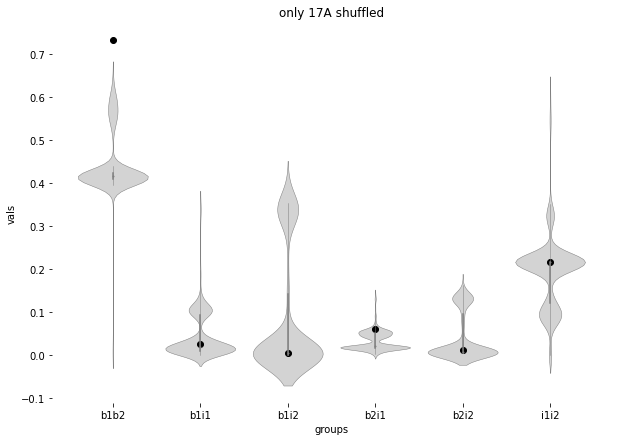

In [223]:
fig = plt.figure(figsize =(10, 7))

# ax = sns.violinplot(x = all_df['groups'], y = all_df['vals'], color = "lightblue", linewidth = 0.5)
ax = sns.violinplot(x = df['groups'], y = df['vals'], color = "lightgrey", linewidth = 0.5)


plt.scatter(0,trueb1b2, marker='o', color = "black")
plt.scatter(1,trueb1i1, marker='o', color = "black")
plt.scatter(2,trueb1i2, marker='o', color = "black")
plt.scatter(3,trueb2i1, marker='o', color = "black")
plt.scatter(4,trueb2i2, marker='o', color = "black")
plt.scatter(5,truei1i2, marker='o', color = "black")

plt.box(False)
plt.title('only 17A shuffled')
plt.show()

In [216]:
d = {'b1b2': all_b1b2, 'b1i1': all_b1i1, 'b1i2': all_b1i2, 'b2i1': all_b2i1, 'b2i2': all_b2i2, 'i1i2': all_i1i2}
all_df = pd.DataFrame(data=d)
all_df = all_df.melt(var_name='groups', value_name='vals')

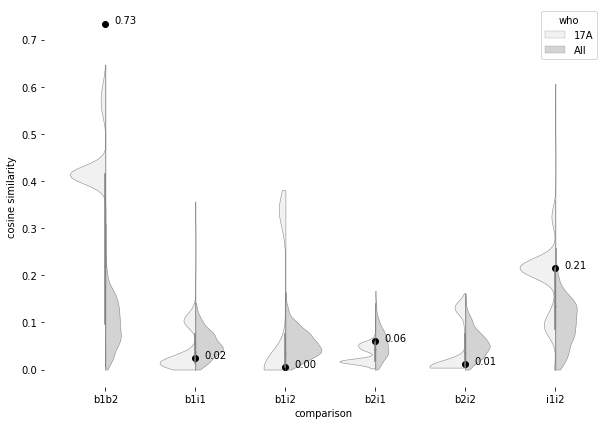

In [258]:
fig = plt.figure(figsize =(10, 7))

# ax = sns.violinplot(x = all_df['groups'], y = all_df['vals'], color = "lightgrey", linewidth = 0.5)
ax = sns.violinplot(x = df2['groups'], y = df2['vals'], hue = df2['who'], split = True, color = "lightgrey", linewidth = 0.5, Legend = False, cut = 0)

plt.scatter(0,trueb1b2, marker='o', color = "black")
plt.scatter(1,trueb1i1, marker='o', color = "black")
plt.scatter(2,trueb1i2, marker='o', color = "black")
plt.scatter(3,trueb2i1, marker='o', color = "black")
plt.scatter(4,trueb2i2, marker='o', color = "black")
plt.scatter(5,truei1i2, marker='o', color = "black")

plt.annotate(str(trueb1b2)[27:31], (0.1, trueb1b2))
plt.annotate(str(trueb1i1)[27:31], (1.1, trueb1i1))
plt.annotate(str(trueb1i2)[27:31], (2.1, trueb1i2))
plt.annotate(str(trueb2i1)[27:31], (3.1, trueb2i1))
plt.annotate(str(trueb2i2)[27:31], (4.1, trueb2i2))
plt.annotate(str(truei1i2)[27:31], (5.1, truei1i2))

# plt.ylim(0,0.8)
plt.box(False)
# plt.title('only 17A shuffled')
plt.ylabel('cosine similarity')
plt.xlabel('comparison')
plt.show()

In [226]:
df['who'] = '17A'
all_df['who'] = 'All'

df2 = df.append(all_df)

In [250]:
str(trueb1b2)[27:31]

'0.73'

In [273]:
adj_temp

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,6,NaN,NaN
2,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,8,29,0,0,NaN,NaN
3,0,0,0,41,0,0,0,0,0,0,...,188,0,0,0,0,0,0,0,NaN,NaN
4,0,0,0,0,0,0,0,0,14,0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,0,12,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,4.0
3194,0,0,0,0,0,0,0,0,0,0,...,0,0,15,0,0,0,0,0,0.0,0.0
3195,52,0,0,0,0,0,0,0,0,0,...,0,0,3,3,0,0,87,0,0.0,0.0
3196,0,0,0,0,0,57,0,58,0,3,...,4,0,0,6,0,0,0,0,0.0,0.0


/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.np modu

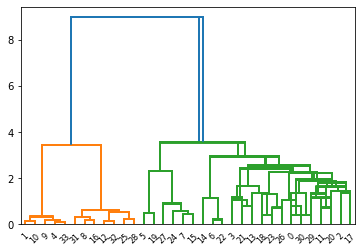

In [285]:
num_shuffles = 1000
j = 0
O_b1b2 = np.empty(num_shuffles)
O_b1i1 = np.empty(num_shuffles)
O_b1i2 = np.empty(num_shuffles)
O_b2i1 = np.empty(num_shuffles)
O_b2i2 = np.empty(num_shuffles)
O_i1i2 = np.empty(num_shuffles)

adj = pd.crosstab(synapse_df['pre_pt_root_id'],synapse_df['post_pt_root_id'])

adj_ = adj[adj.index.isin(other_pmn_df.SegID.to_list())]
adj_not = adj[~adj.index.isin(other_pmn_df.SegID.to_list())]
adj_not.columns = range(0,len(adj_not.columns))

while j < num_shuffles:

    i = 0
    # shuffled_adj = pd.DataFrame(pd.np.empty((adj.shape[0], adj.shape[1])))
    shuffled_adj = pd.DataFrame(pd.np.empty((adj_.shape[0], adj_.shape[1])))
    while i < adj.shape[1]:
        x = np.array(adj_.iloc[:,i])
        x_ = resample_with_replacement(x)
        shuffled_adj.iloc[:,i] = x_
        i = i +1

    adj_temp = shuffled_adj.merge(adj_not, how = 'outer')

    sim_mat_temp = cosine_similarity(adj_temp.to_numpy().transpose())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj_temp.iloc[:,clustered_order]
    shuffled_sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())

    shuffled_sim_mat_df = pd.DataFrame(shuffled_sim_mat, columns=[lbls], index = lbls)

    O_b1b2[j] = shuffled_sim_mat_df.loc['b1', 'b2']
    O_b1i1[j] = shuffled_sim_mat_df.loc['b1', 'i1']
    O_b1i2[j] = shuffled_sim_mat_df.loc['b1', 'i2?']
    O_b2i1[j] = shuffled_sim_mat_df.loc['b2', 'i1']
    O_b2i2[j] = shuffled_sim_mat_df.loc['b2', 'i2?']
    O_i1i2[j] = shuffled_sim_mat_df.loc['i1', 'i2?']

    j = j +1



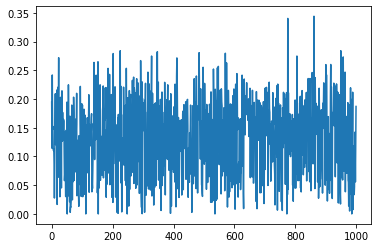

In [279]:
plt.plot(L_b1b2)

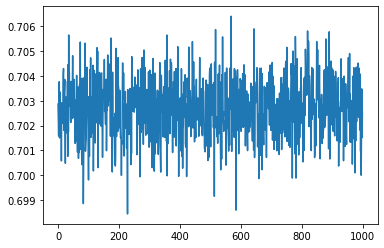

In [286]:
plt.plot(O_b1b2)

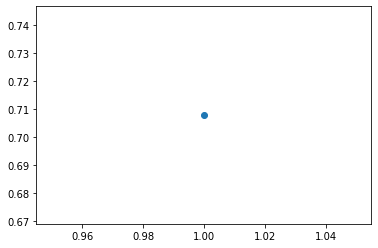

In [268]:
plt.plot(1,A_b1b2, marker = 'o')

In [343]:
del all_df
del d
d = {'Local': L_b1b2, 'Ascending': asc_b1b2, 'Sensory': S_b1b2, 'Descending': D_b1b2, 'Other': O_b1b2}
all_df = pd.DataFrame(data=d)
all_df = all_df.melt(var_name='groups', value_name='vals')

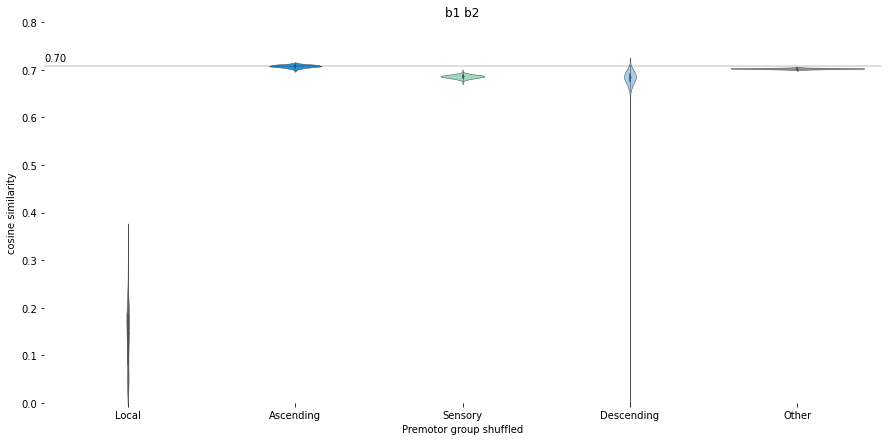

In [357]:
fig = plt.figure(figsize =(15, 7))

colors = ["#916e99","#069af3","#90e4c1","#95d0fc","#929591"]
cmap = sns.set_palette(sns.color_palette(colors))
ax = sns.violinplot(x = all_df['groups'], y = all_df['vals'], linewidth = 0.5)

plt.axhline(y=float(A_b1b2), color="black", linestyle='-', linewidth = 0.25)
plt.annotate(str(A_b1b2)[27:31], (-0.5, float(A_b1b2)+0.01))

plt.ylim(0,0.8)
plt.box(False)
plt.title('b1 b2')
plt.ylabel('cosine similarity')
plt.xlabel('Premotor group shuffled')
plt.savefig('b1b2shuffle.eps', format='eps', bbox_inches='tight')

plt.show()

In [295]:
float(A_b1b2)

0.7078805969804672

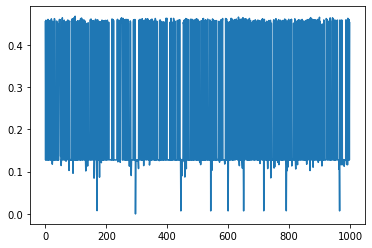

In [332]:
plt.plot(S_i1i2)

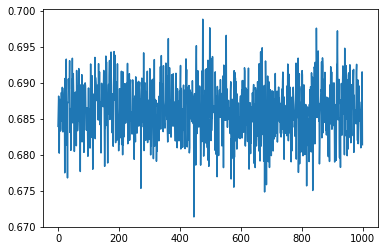

In [310]:
plt.plot(S_b1b2)

In [361]:
adj_ = adj[adj.index.isin(local_df.SegID.to_list())]

len(adj_)

1092

In [365]:
adj_

post_pt_root_id,648518346459589124,648518346472269618,648518346472328139,648518346472953700,648518346476906768,648518346481269135,648518346481319311,648518346482131604,648518346483122508,648518346486563887,...,648518346498479344,648518346499049025,648518346499256923,648518346499823171,648518346509427075,648518346509604297,648518346510983810,648518346511825599,648518346512153646,648518346515087943
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346459413252,0,0,0,0,0,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346459550468,0,10,0,0,15,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,7
648518346459573508,3,0,0,0,0,0,0,0,0,0,...,0,0,35,0,0,5,48,0,0,0
648518346459589380,14,0,0,0,0,0,0,0,0,0,...,0,0,14,0,0,0,0,0,0,0
648518346459591428,0,0,0,0,0,0,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346531254810,0,0,0,0,0,0,0,0,0,0,...,0,0,15,0,0,0,0,0,0,0
648518346531262490,52,0,0,0,0,0,0,0,0,0,...,0,0,3,3,0,0,87,0,0,0
648518346531278362,0,0,0,0,0,57,0,58,0,3,...,4,0,0,6,0,0,0,0,0,0


In [379]:
temp = descending_syn[descending_syn.post_pt_root_id.isin([648518346459589124,648518346499256923])]
len(temp.pre_pt_root_id.value_counts())

42